In [437]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from financetoolkit import Toolkit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import plotly.express as px
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*60)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = "USREC","FRBKCLMCILA","UNRATE","U6RATE","LNS12032195","ICSA","UEMP27OV","EMRATIO","USPRIV","TEMPHELPS","AWHI","AHETPI","LNS17100000","JTS1000HIR","NECDFSA066MSFRBPHI","LNS13023622","LNS14023705","JTS1000QUR","CIVPART","PAYEMS","USGOVT","CES9091000001","CES9092000001","CES9093000001","LNS13008517","CLF16OV","UNEMPLOY","CE16OV","LNS13023706","USGOVT","USEHS","USLAH","USMINE","USCONS","MANEMP","USTPU","USINFO","USFIRE","USPBS","USSERV","CES6562000001","JTSJOR","JTSTSL","ECIWAG","JTS1000HIL","JTSJOL","ULCNFB","CPIAUCSL","DPCERD3Q086SBEA","CEU0500000003","A132RC1Q027SBEA","CES0500000003","IA001260M","AWHAETP","RSXFS"

    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["SPY",'RSP',"XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
                            "GDXJ","MBB", "UUP","IIGD","PINK","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
                           '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
                           'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLC','XLB','BIL',
                           'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
                           'SPDW','XTN','SPMB','SLYV','EFIV','EFAX','MDYV','AGG','LQD','^VIX','^VVIX'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]

In [438]:
initial = Macro(0, '2010-01-01','2023-05-01')

In [439]:
inst = initial.macro()
data = inst[1]

In [440]:
labor = ['UNRATE','FRBKCLMCILA']
rec = ["USREC"]  
start = '1959-01-01'
end = dt.datetime.now()
usrec_data = initial.dataframe(rec, data.set_index("DATE"), start, end)
unemployment = initial.dataframe(labor, data.set_index("DATE"), start, end)
unemployment['KC LMCI Inverted'] = abs(unemployment['FRBKCLMCILA']-unemployment['FRBKCLMCILA'].max())
unemployment['KC LMCI Inverted Shifted Up 2.8'] = unemployment['KC LMCI Inverted']+2.8
unemployment = unemployment.rename(columns = {'UNRATE':'Unemployment Rate','FRBKCLMCILA':'KC LMCI'})

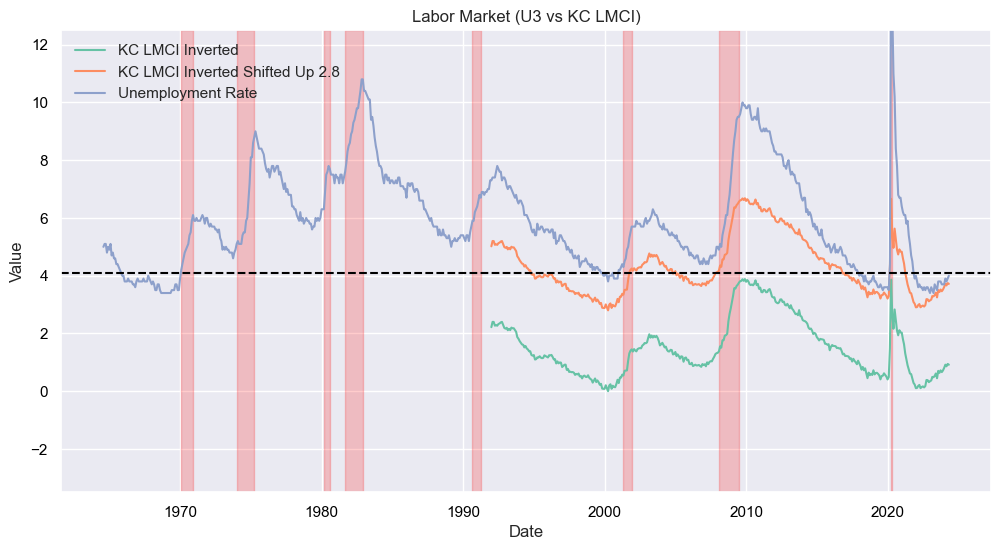

In [441]:
def fetch_recession_periods(usrec, start_date, end_date):
    recessions = {}
    recession_num = 0
    start = None
    for i in range(len(usrec)):
        if usrec.iloc[i, 0] == 1:  
            if start is None:  
                start = usrec.index[i]  
                start = datetime(start.year, start.month, calendar.monthrange(start.year, start.month)[1])
            end = usrec.index[i]
            end = datetime(end.year, end.month, calendar.monthrange(end.year, end.month)[1])
        elif start is not None:  
            recession_num += 1
            recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
            start = None  
    if start is not None:
        recession_num += 1
        recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
    if usrec.iloc[0, 0] == 1:
        first_start = usrec.index[0] - pd.offsets.MonthBegin(1)
        first_start = datetime(first_start.year, first_start.month, calendar.monthrange(first_start.year, first_start.month)[1])
        recessions[1]['start'] = first_start.strftime('%Y-%m-%d')
    return recessions

def add_recession_bands(ax, recessions, start_date, end_date):
    plot_start_date = pd.to_datetime(start_date)
    plot_end_date = pd.to_datetime(end_date)
    for rec_num, rec_dates in recessions.items():
        rec_start_date = pd.to_datetime(rec_dates['start'])
        rec_end_date = pd.to_datetime(rec_dates['end'])
        if (rec_start_date <= plot_end_date) and (rec_end_date >= plot_start_date):
            ax.axvspan(rec_start_date, rec_end_date, color="red", alpha=0.2)

def eco_plot(df_data, start_date, end_date, title, y_min, y_max , xline, xupperline, plot=False, save_fig=False):
    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(data=df_data, dashes=False, ax=ax, palette="Set2")  # "tab10", viridis, hls, "Set2"
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend(frameon=False, loc = 'upper left')
        ax.tick_params(axis='x', colors='black')  
        ax.tick_params(axis='y', colors='black')  
        recessions = fetch_recession_periods(usrec_data,'1960-01-01', end_date)
        add_recession_bands(ax, recessions, start_date, end_date)
        ax.set_ylim(y_min, y_max)
        plt.axhline(xline, color='black', linestyle='--')
        plt.axhline(xupperline, color='black', linestyle='--')
        if save_fig:
            plt.savefig(f'{end_date}_cf_nai.png', bbox_inches='tight', transparent=False)
        plt.show()
    else:
        return df_data

eco_plot(unemployment[['KC LMCI Inverted','KC LMCI Inverted Shifted Up 2.8','Unemployment Rate']], start, end, 'Labor Market (U3 vs KC LMCI)', -3.5, 12.5, 4.1, 100, plot=True, save_fig=False)

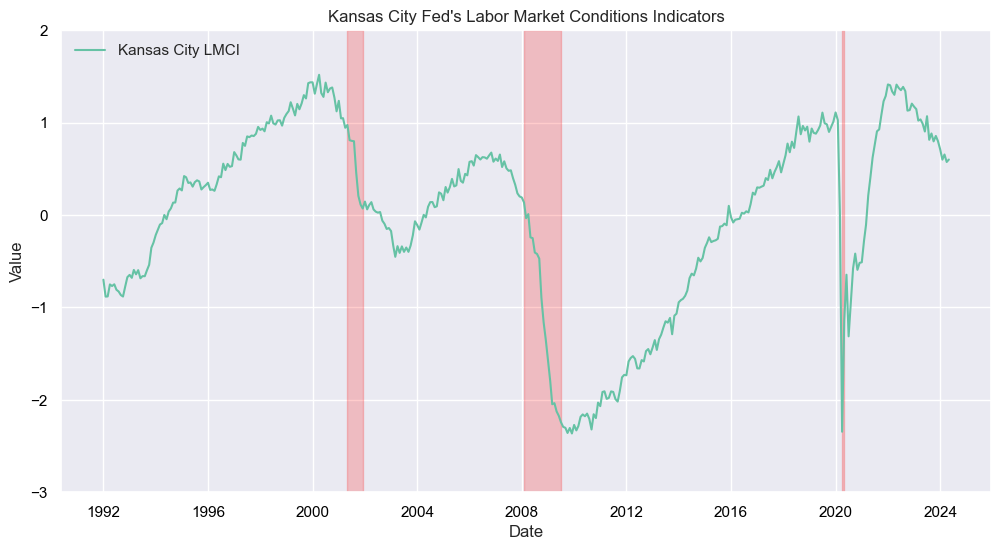

In [442]:
kc = ['FRBKCLMCILA']
start = '1970-01-02'
end = dt.datetime.now()
kclmni = initial.dataframe(kc, data.set_index("DATE"), start, end)
kclmni = kclmni.rename(columns = {'FRBKCLMCILA':'Kansas City LMCI'})
eco_plot(kclmni, '1992-01-01', end, "Kansas City Fed's Labor Market Conditions Indicators", -3, 2, -100, 100, plot=True, save_fig=False)

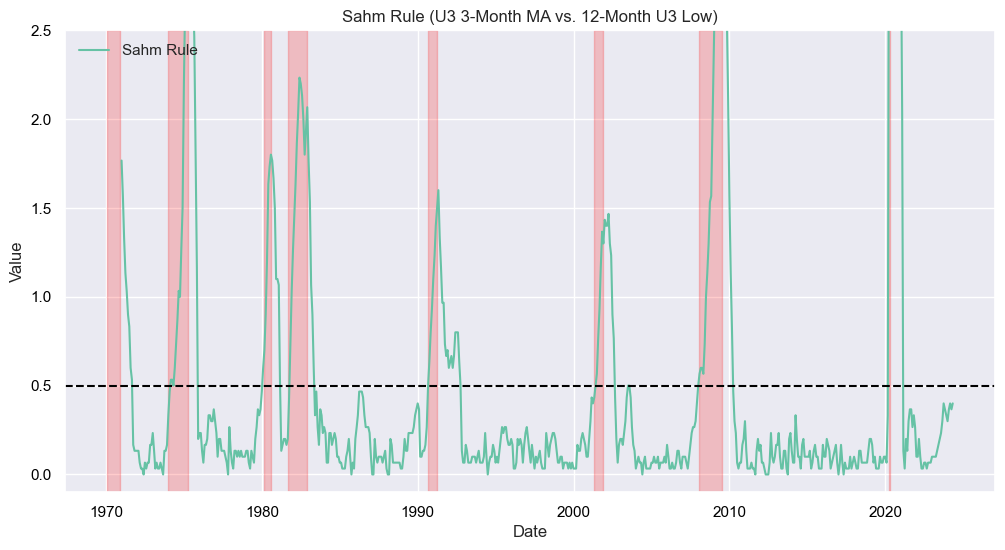

In [443]:
labor = ['UNRATE']
start = '1970-01-02'
end = dt.datetime.now()
unemployment = initial.dataframe(labor, data.set_index("DATE"), start, end)
unemployment = unemployment.rename(columns = {'UNRATE':'U3 Unemployment Rate'})
unemployment = unemployment.fillna(method='ffill')
unemployment['3mo Moving Average'] = unemployment['U3 Unemployment Rate'].rolling(window = 3).mean()
unemployment['Lowest 12 Month'] = unemployment['U3 Unemployment Rate'].rolling(window = 12).min()
unemployment['Sahm Rule'] = unemployment['3mo Moving Average'] - unemployment['Lowest 12 Month']
sahm = unemployment.dropna()
eco_plot(sahm[['Sahm Rule']], start, end, 'Sahm Rule (U3 3-Month MA vs. 12-Month U3 Low)', -0.1, 2.5, 0.5, 100, plot=True, save_fig=False)

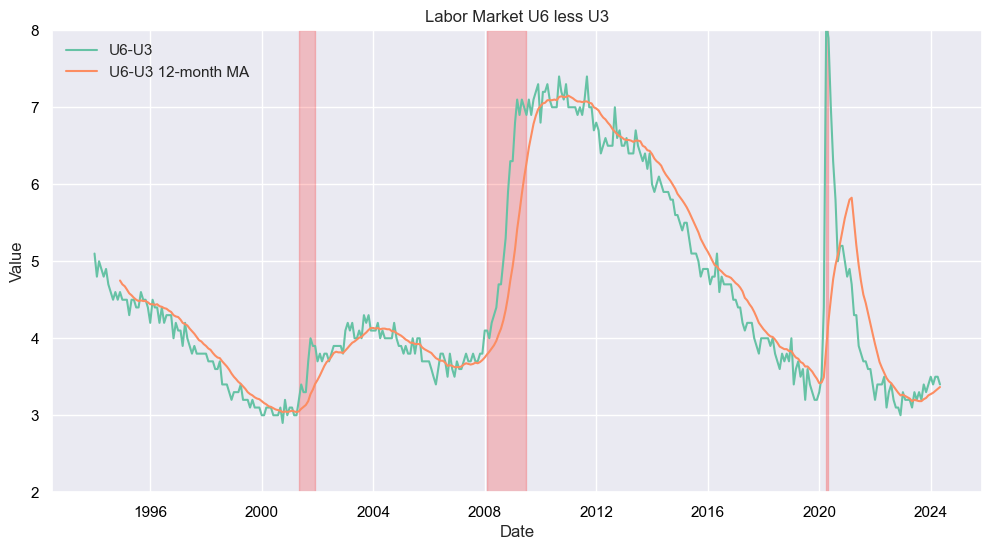

In [444]:
labor = ['UNRATE','U6RATE']
start = '1990-01-02'
end = dt.datetime.now()
unemployment = initial.dataframe(labor, data.set_index("DATE"), start, end)
unemployment['U6-U3'] = unemployment['U6RATE'] - unemployment['UNRATE']
unemployment['U6-U3 12-month MA'] = unemployment['U6-U3'].rolling(window=12).mean()
unemployment = unemployment.rename(columns = {'UNRATE':'Unemployment Rate','U6RATE':'U-6 Rate'})
eco_plot(unemployment[['U6-U3','U6-U3 12-month MA']], '1996-01-01', end, 'Labor Market U6 less U3', 2, 8, -4.1, 100, plot=True, save_fig=False)

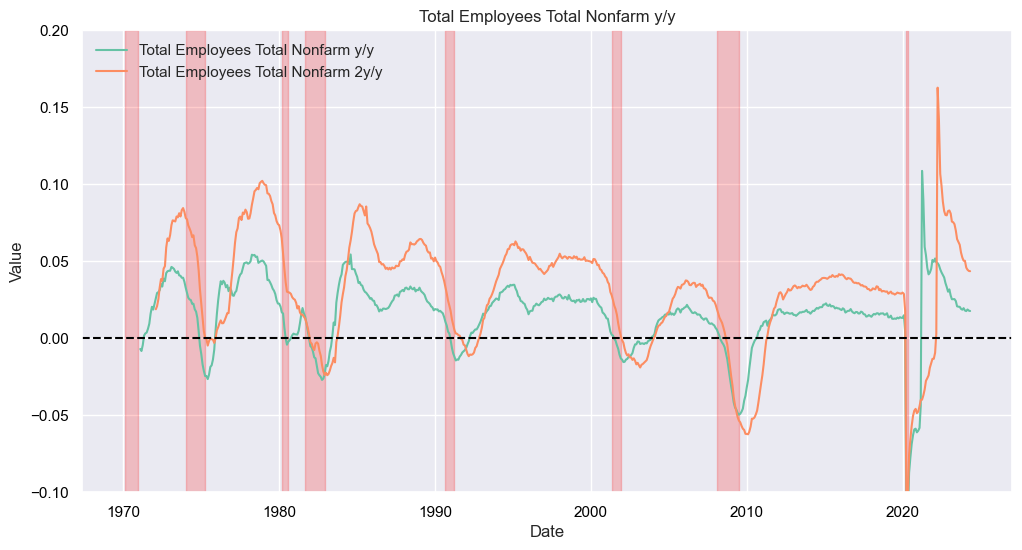

In [445]:
nfp = ['PAYEMS']
start = '1970-01-02'
end = dt.datetime.now()
payems = initial.dataframe(nfp, data.set_index("DATE"), start, end)
payems['Total Employees Total Nonfarm y/y'] = (payems['PAYEMS'] / payems['PAYEMS'].shift(12))-1
payems['Total Employees Total Nonfarm 2y/y'] = (payems['PAYEMS'] / payems['PAYEMS'].shift(12*2))-1
payems_yoy = payems[['Total Employees Total Nonfarm y/y','Total Employees Total Nonfarm 2y/y']]
eco_plot(payems_yoy, start, end, 'Total Employees Total Nonfarm y/y', -.1, .2, 0.00, 1000, plot=True, save_fig=False)

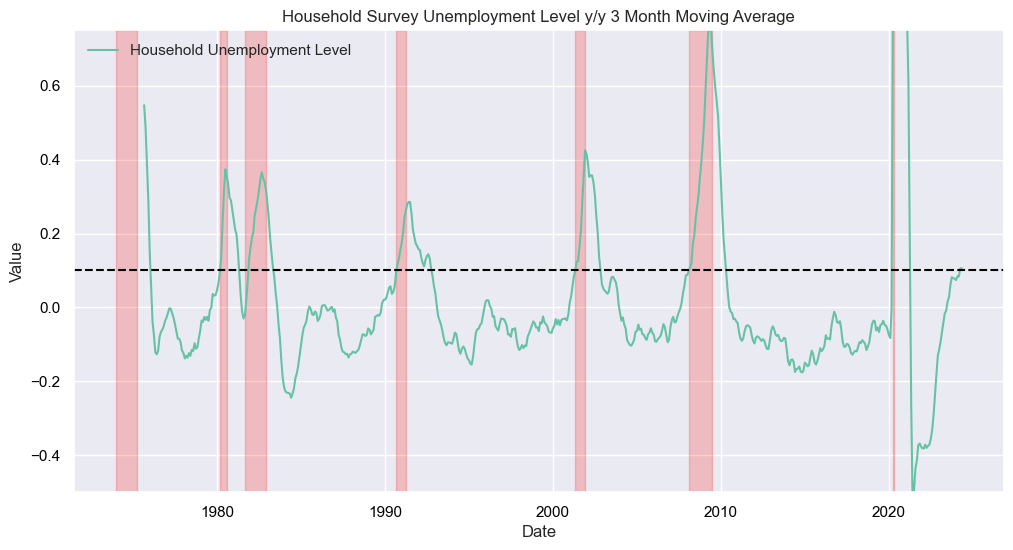

In [446]:
household = ['UNEMPLOY']
start = '1974-07-01'
end = dt.datetime.now()
household1 = initial.dataframe(household, data.set_index("DATE"), start, end)
household1 = household1.rename(columns = {'UNEMPLOY':'Household Unemployment Level'})
household2 = (((household1 / household1.shift(12))-1).dropna()).rolling(window=3).mean().dropna()
eco_plot(household2[['Household Unemployment Level']], '1975-01-01', end, 'Household Survey Unemployment Level y/y 3 Month Moving Average', -0.5, 0.75, .10, 100, plot=True, save_fig=False)

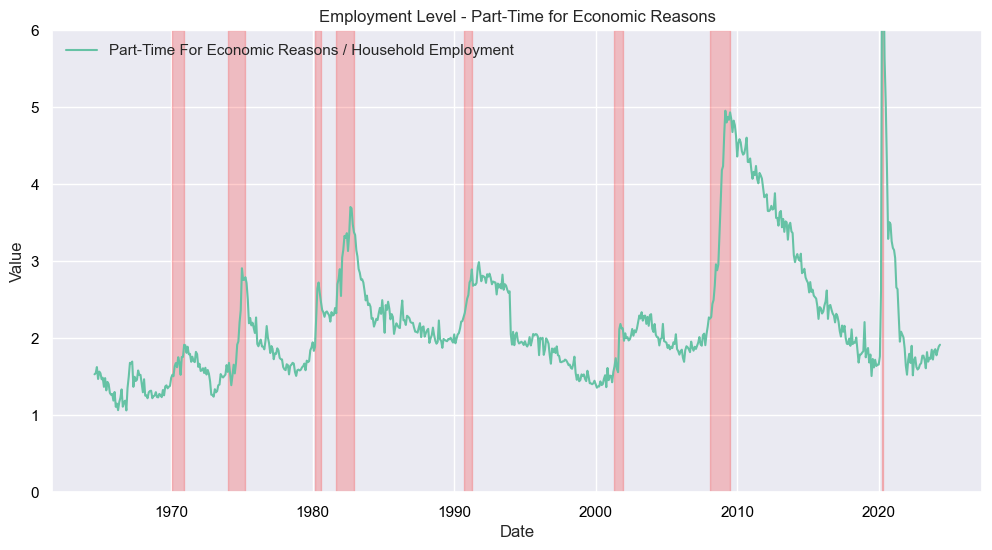

In [447]:
pt_eco = ['LNS12032195','CE16OV']
start = '1950-01-02'
end = dt.datetime.now()
pt_eco1 = initial.dataframe(pt_eco, data.set_index("DATE"), start, end)
pt_eco1['Part-Time For Economic Reasons / Household Employment'] = (pt_eco1['LNS12032195'] / pt_eco1['CE16OV'])*100
pt_eco1 = pt_eco1.rename(columns = {"LNS12032195":"Employment Level - Part-Time for Economic Reasons, Slack Work or Business Conditions, All Industries",
                                    "CE16OV": "Level of Household Employment"})
eco_plot(pt_eco1[['Part-Time For Economic Reasons / Household Employment']], start, end, "Employment Level - Part-Time for Economic Reasons", 0, 6, -100, -100, plot=True, save_fig=False)

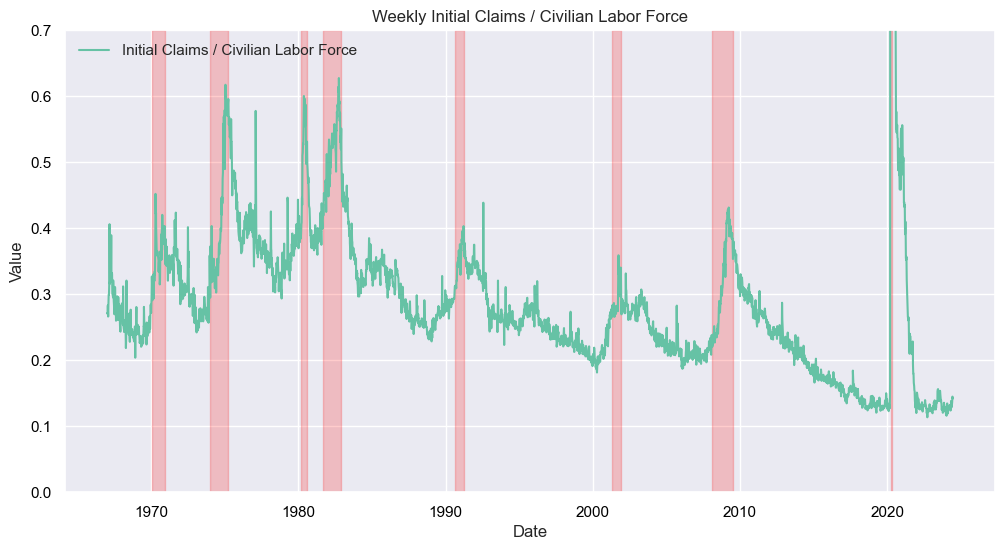

In [448]:
ic = ['ICSA','CLF16OV']
start = '1950-01-02'
end = dt.datetime.now()
claims = initial.dataframe(ic, data.set_index("DATE"), start, end)
claims = claims.fillna(method='ffill').dropna()
claims['CLF16OV_unadjusted'] = claims['CLF16OV']*1000
claims['Initial Claims / Civilian Labor Force'] = 100 * (claims['ICSA'] / claims['CLF16OV_unadjusted'])
eco_plot(claims[['Initial Claims / Civilian Labor Force']], start, end, "Weekly Initial Claims / Civilian Labor Force", 0, 0.7, -100, -100, plot=True, save_fig=False)

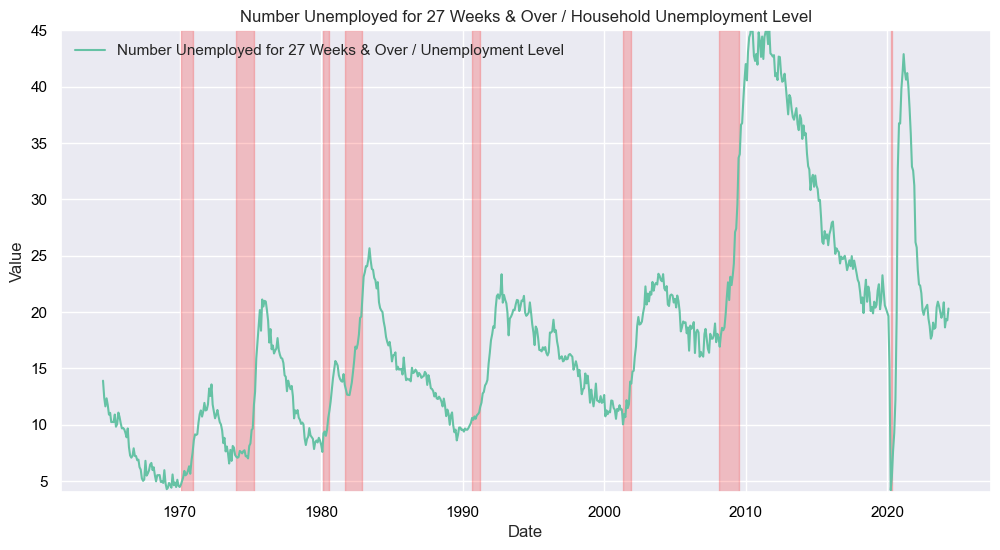

In [449]:
ic_27 = ['UEMP27OV','UNEMPLOY']
start = '1950-01-02'
end = dt.datetime.now()
ic27 = initial.dataframe(ic_27, data.set_index("DATE"), start, end)
ic27['Number Unemployed for 27 Weeks & Over / Unemployment Level'] = 100 * (ic27['UEMP27OV'] / ic27['UNEMPLOY'])
eco_plot(ic27[['Number Unemployed for 27 Weeks & Over / Unemployment Level']], start, end, "Number Unemployed for 27 Weeks & Over / Household Unemployment Level", 4, 45, -100, -100, plot=True, save_fig=False)

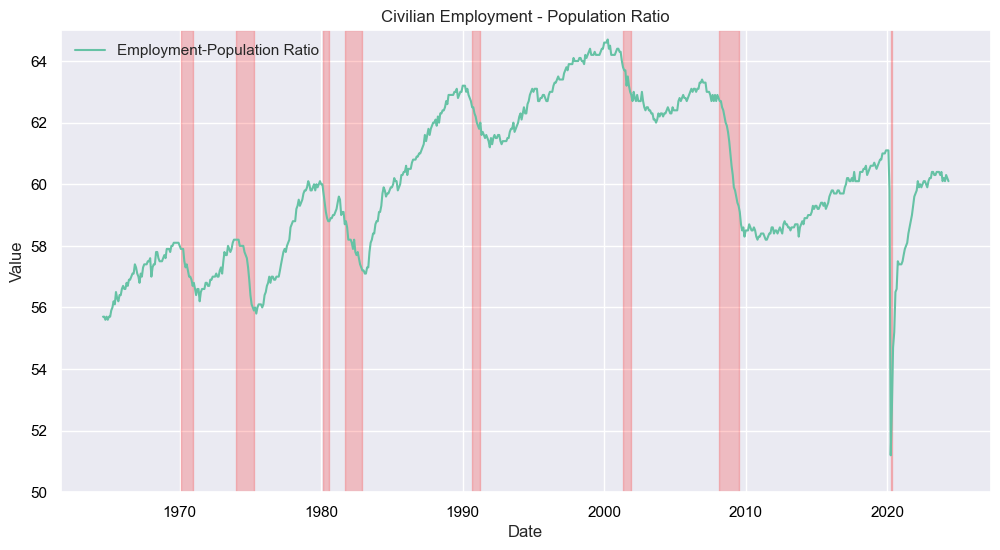

In [450]:
ep_ratio = ['EMRATIO']
start = '1950-01-02'
end = dt.datetime.now()
ep_ratio1 = initial.dataframe(ep_ratio, data.set_index("DATE"), start, end)
ep_ratio1 = ep_ratio1.rename(columns = {"EMRATIO":"Employment-Population Ratio"})
eco_plot(ep_ratio1, start, end, "Civilian Employment - Population Ratio", 50, 65, -100, -100, plot=True, save_fig=False)

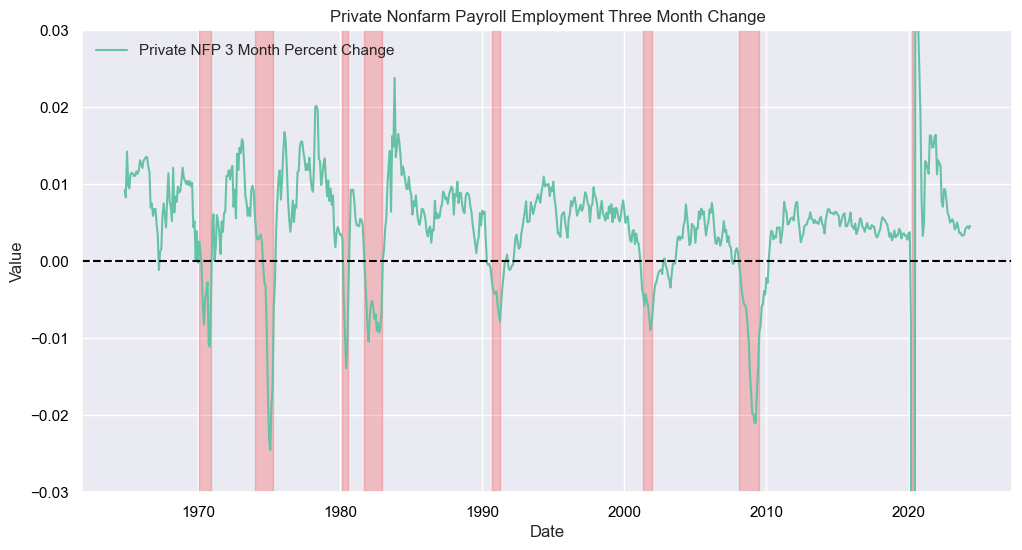

In [451]:
nfp_priv = ['USPRIV']
start = '1950-01-02'
end = dt.datetime.now()
nfp_priv1 = initial.dataframe(nfp_priv, data.set_index("DATE"), start, end)
nfp_priv1['Private NFP 3 Month Percent Change'] = (nfp_priv1['USPRIV'] / nfp_priv1['USPRIV'].shift(3))-1
eco_plot(nfp_priv1[['Private NFP 3 Month Percent Change']], start, end, "Private Nonfarm Payroll Employment Three Month Change", -0.03, 0.03, 0.00, -100, plot=True, save_fig=False)

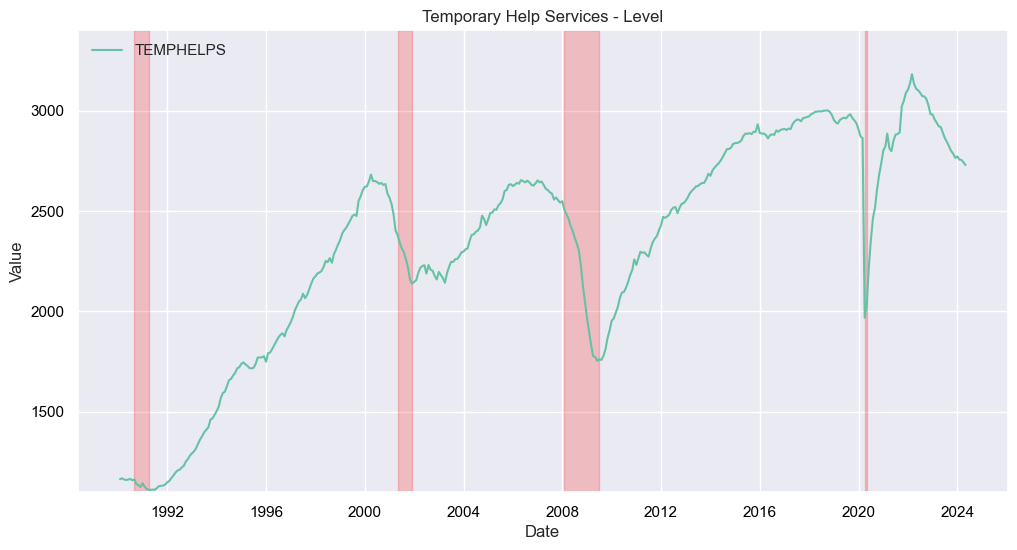

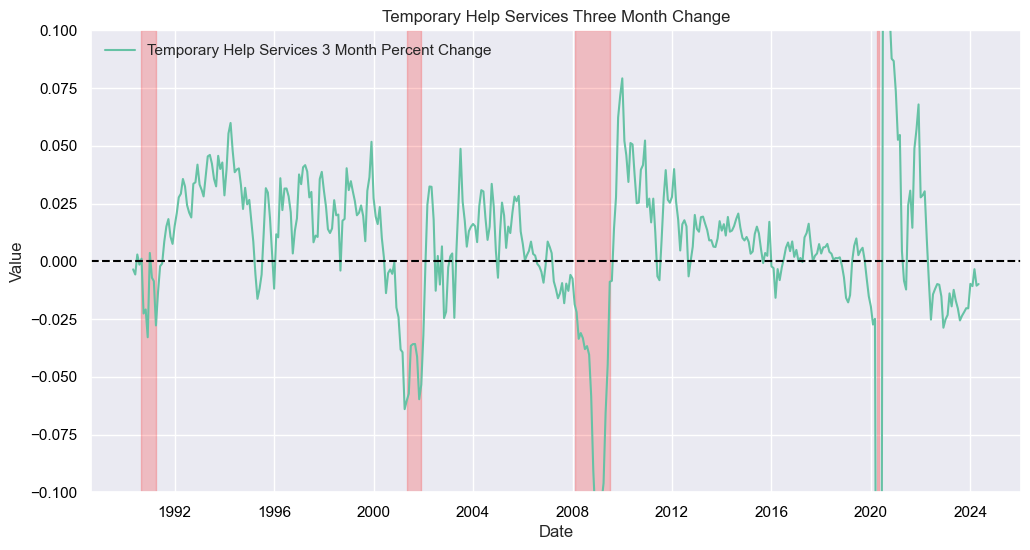

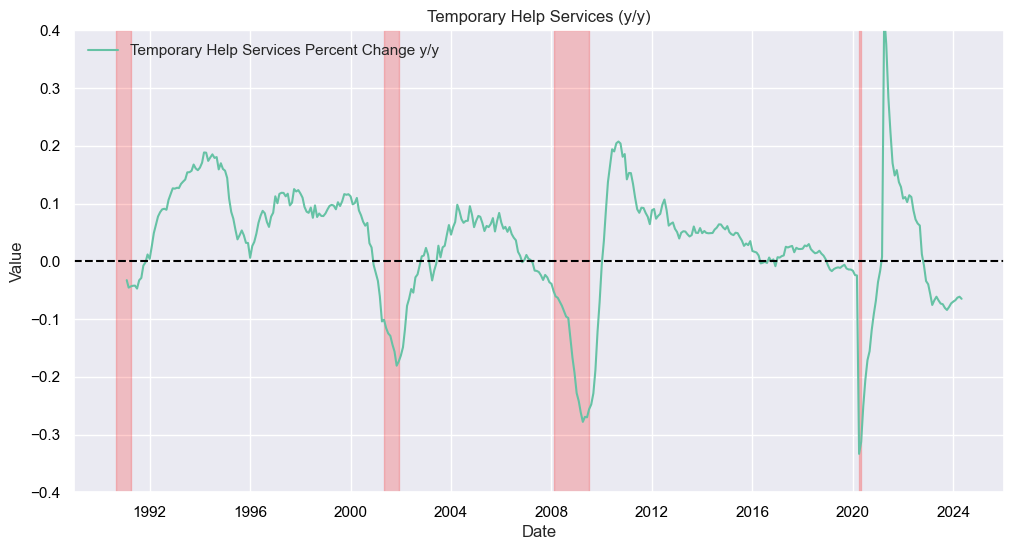

In [452]:
temp = ['TEMPHELPS']
start = '1990-01-02'
end = dt.datetime.now()
temp1 = initial.dataframe(temp, data.set_index("DATE"), start, end)
temp1['Temporary Help Services 3 Month Percent Change'] = (temp1['TEMPHELPS'] / temp1['TEMPHELPS'].shift(3))-1
temp1['Temporary Help Services Percent Change y/y'] = (temp1['TEMPHELPS'] / temp1['TEMPHELPS'].shift(12))-1

eco_plot(temp1[['TEMPHELPS']], start, end, "Temporary Help Services - Level", 1100, 3400, 0.00, -100, plot=True, save_fig=False)
eco_plot(temp1[['Temporary Help Services 3 Month Percent Change']], start, end, "Temporary Help Services Three Month Change", -0.1, 0.1, 0.00, -100, plot=True, save_fig=False)
eco_plot(temp1[['Temporary Help Services Percent Change y/y']], start, end, "Temporary Help Services (y/y)", -0.4, 0.4, 0.00, -100, plot=True, save_fig=False)

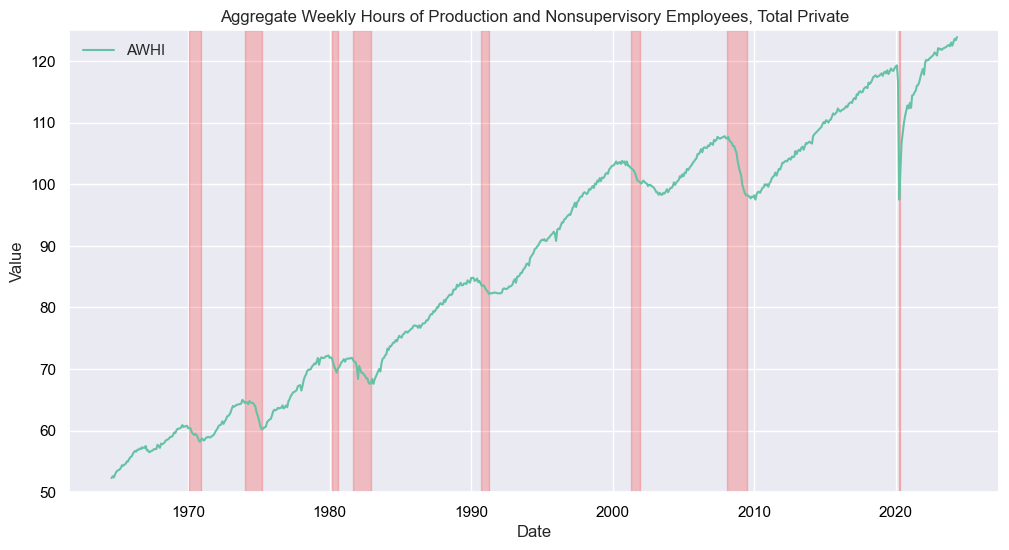

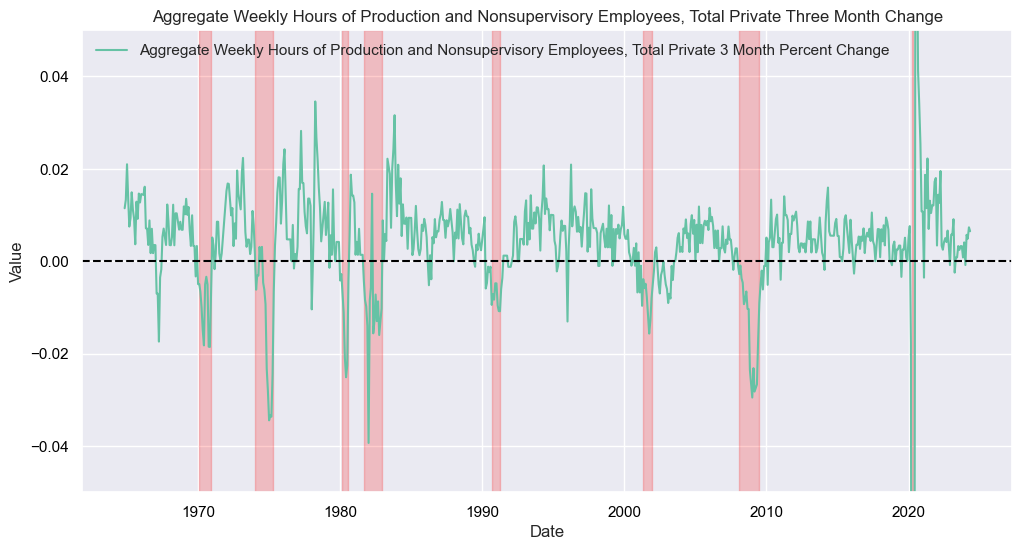

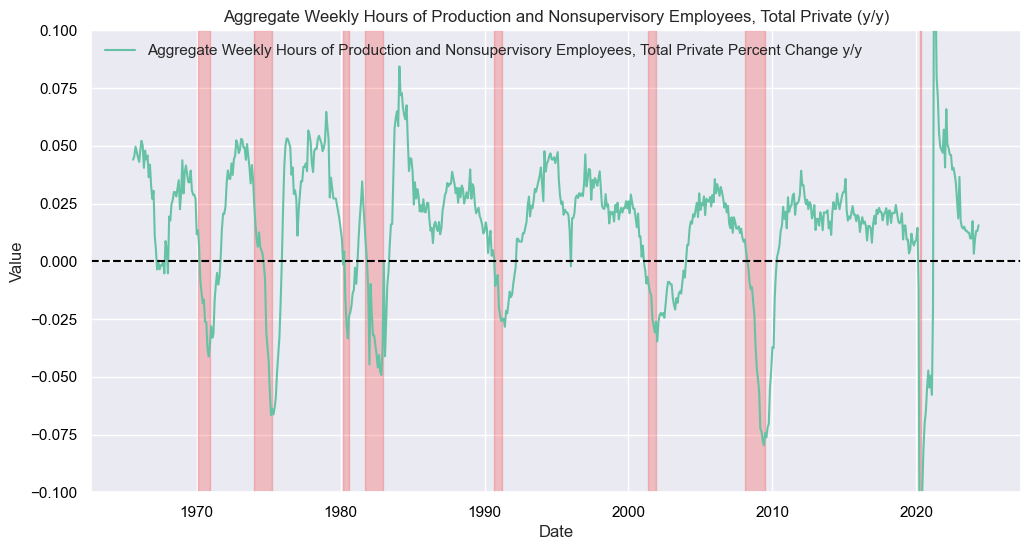

In [453]:
wh = ['AWHI']
start = '1950-01-02'
end = dt.datetime.now()
wh1 = initial.dataframe(wh, data.set_index("DATE"), start, end)
wh1['Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private 3 Month Percent Change'] = (wh1['AWHI'] / wh1['AWHI'].shift(3))-1
wh1['Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private Percent Change y/y'] = (wh1['AWHI'] / wh1['AWHI'].shift(12))-1

eco_plot(wh1[['AWHI']], start, end, "Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private", 50, 125, 0.00, -100, plot=True, save_fig=False)
eco_plot(wh1[['Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private 3 Month Percent Change']], start, end, "Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private Three Month Change", -0.05, 0.05, 0.00, -100, plot=True, save_fig=False)
eco_plot(wh1[['Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private Percent Change y/y']], start, end, "Aggregate Weekly Hours of Production and Nonsupervisory Employees, Total Private (y/y)", -0.1, 0.1, 0.00, -100, plot=True, save_fig=False)

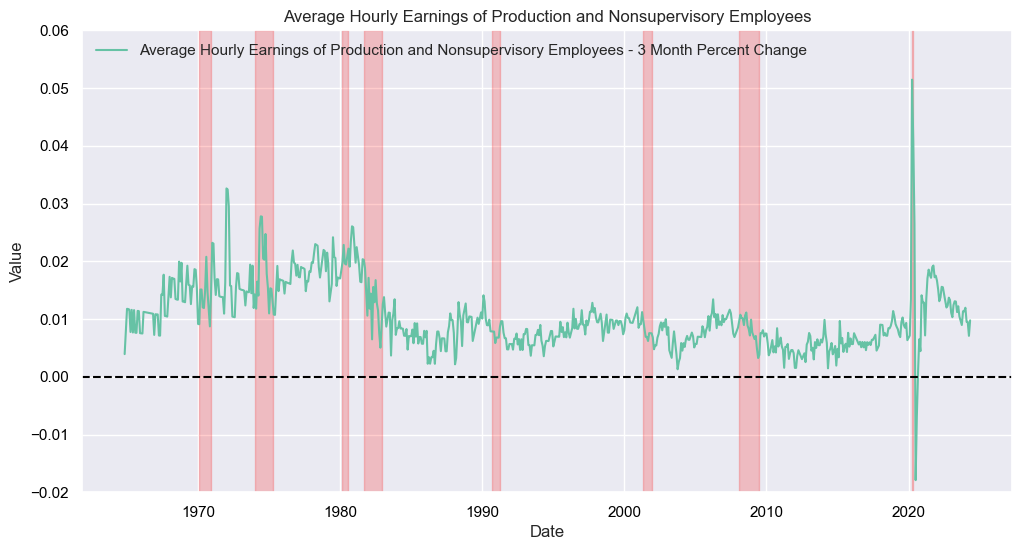

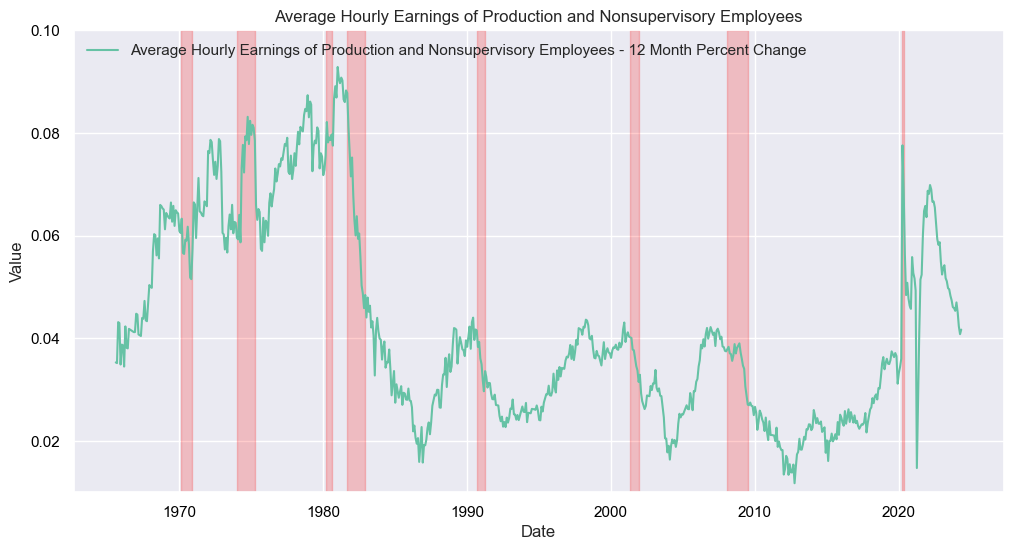

In [454]:
ahe = ['AHETPI']
start = '1950-01-02'
end = dt.datetime.now()
ahe1 = initial.dataframe(ahe, data.set_index("DATE"), start, end)
ahe1['Average Hourly Earnings of Production and Nonsupervisory Employees - 3 Month Percent Change'] = (ahe1['AHETPI'] / ahe1['AHETPI'].shift(3))-1
ahe1['Average Hourly Earnings of Production and Nonsupervisory Employees - 12 Month Percent Change'] = (ahe1['AHETPI'] / ahe1['AHETPI'].shift(12))-1
eco_plot(ahe1[['Average Hourly Earnings of Production and Nonsupervisory Employees - 3 Month Percent Change']], start, end, "Average Hourly Earnings of Production and Nonsupervisory Employees", -0.02, 0.06, 0.00, -100, plot=True, save_fig=False)
eco_plot(ahe1[['Average Hourly Earnings of Production and Nonsupervisory Employees - 12 Month Percent Change']], start, end, "Average Hourly Earnings of Production and Nonsupervisory Employees", 0.01, 0.1, 0.00, -100, plot=True, save_fig=False)

In [455]:
eci_jolts = ['ECIWAG','JTS1000QUR']
start = '2000-01-02'
end = dt.datetime.now()
eci_jolts1 = initial.dataframe(eci_jolts, data.set_index("DATE"), start, end)
eci_jolts1['Quits: Total Private 9mo Lead'] = eci_jolts1['JTS1000QUR'].shift(9)
eci_jolts1 = eci_jolts1.rename(columns = {"ECIWAG":"ECI: Wages and Salaries: Private Industry Workers"})
eci_jolts1 = eci_jolts1[["Quits: Total Private 9mo Lead","ECI: Wages and Salaries: Private Industry Workers"]]
ec1 = eci_jolts1[['ECI: Wages and Salaries: Private Industry Workers']].dropna()
ec1 = ((ec1 / ec1.shift(4))-1).dropna() * 100
eci_jolts2 = pd.concat([eci_jolts1[['Quits: Total Private 9mo Lead']],ec1],axis=1).fillna(method = 'ffill').dropna()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=eci_jolts2.index, y=eci_jolts2['ECI: Wages and Salaries: Private Industry Workers'], name="ECI: Private Industry Workers"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=eci_jolts2.index, y=eci_jolts2['Quits: Total Private 9mo Lead'].rolling(window=3).mean(), name="Quits: Total Private 9mo Lead"),
    secondary_y=True,)
fig.update_layout(
    title_text="Quits Rate Leads the Employment Cost Index by 9-Months",
    width=800,
    height=600)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>ECI</b> Private Industry Workers", secondary_y=False)
fig.update_yaxes(title_text="<b>Quits</b> Total Private 9mo Lead 3mo MA", secondary_y=True)
fig.show()

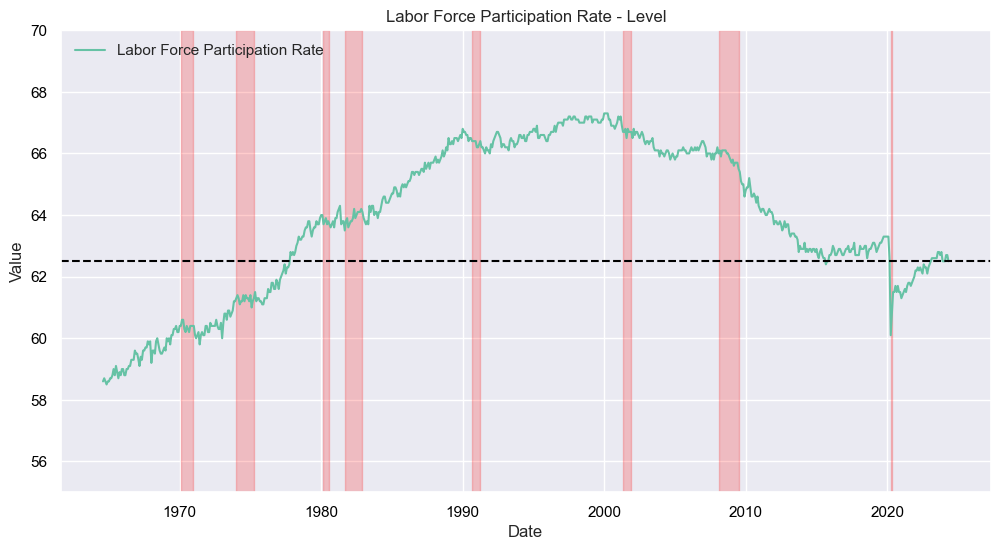

In [456]:
lfpr = ['CIVPART']
start = '1950-01-02'
end = dt.datetime.now()
lfpr1 = initial.dataframe(lfpr, data.set_index("DATE"), start, end)
lfpr1 = lfpr1.rename(columns = {"CIVPART":"Labor Force Participation Rate"})
eco_plot(lfpr1[['Labor Force Participation Rate']], start, end, "Labor Force Participation Rate - Level", 55, 70, 62.5, -100, plot=True, save_fig=False)

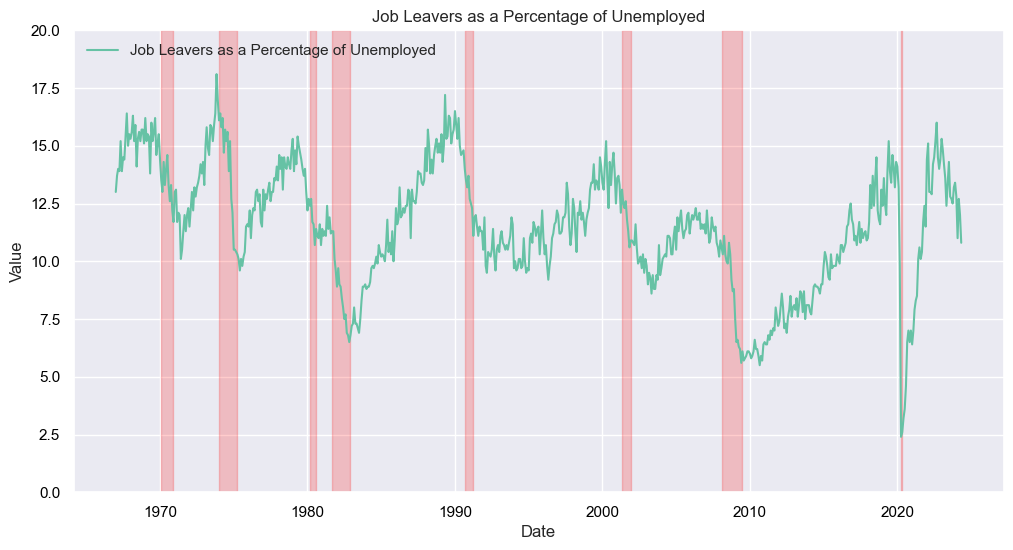

In [457]:
job_leavers = ["LNS13023706"]
start = '1950-01-02'
end = dt.datetime.now()
job_leavers1 = initial.dataframe(job_leavers, data.set_index("DATE"), start, end)
job_leavers1 = job_leavers1.rename(columns = {"LNS13023706":"Job Leavers as a Percentage of Unemployed"})
eco_plot(job_leavers1[['Job Leavers as a Percentage of Unemployed']], start, end, "Job Leavers as a Percentage of Unemployed", 0, 20, 62.5, -100, plot=True, save_fig=False)

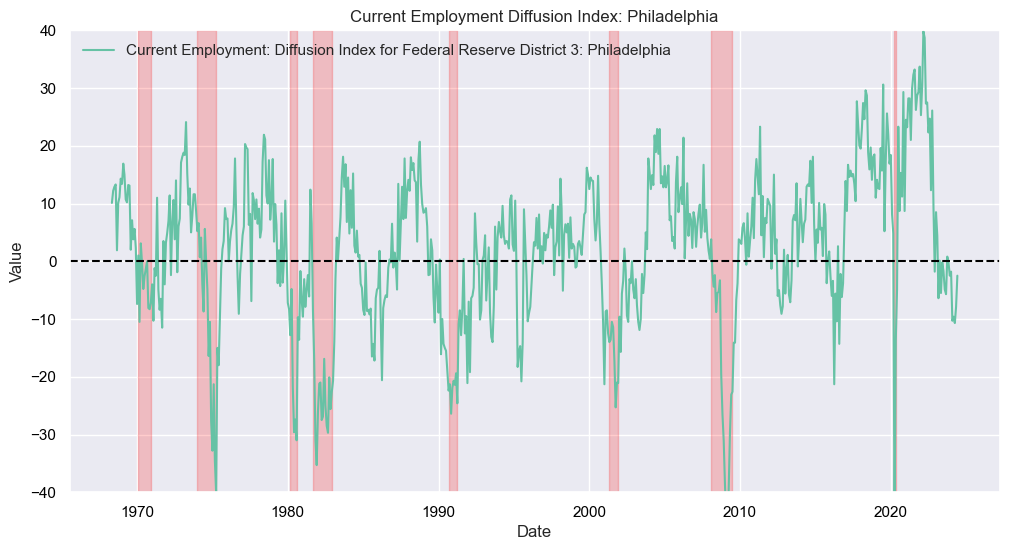

In [458]:
diffusion = ["NECDFSA066MSFRBPHI"]
start = '1950-01-02'
end = dt.datetime.now()
diffusion1 = initial.dataframe(diffusion, data.set_index("DATE"), start, end)
diffusion1 = diffusion1.rename(columns = {"NECDFSA066MSFRBPHI":"Current Employment: Diffusion Index for Federal Reserve District 3: Philadelphia"})
eco_plot(diffusion1[['Current Employment: Diffusion Index for Federal Reserve District 3: Philadelphia']], start, end, "Current Employment Diffusion Index: Philadelphia", -40, 40, 0, -100, plot=True, save_fig=False)

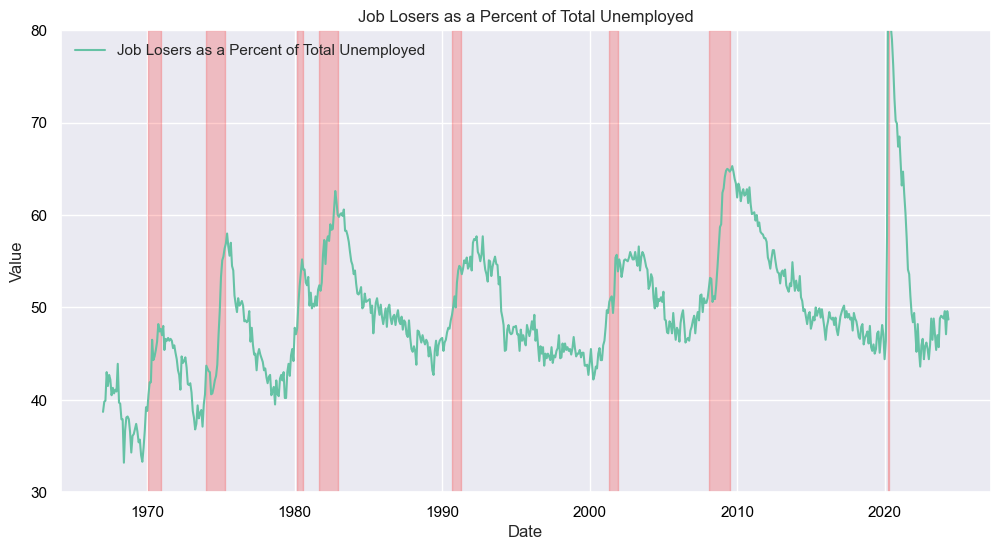

In [459]:
job_leavers = ["LNS13023622"]
start = '1950-01-02'
end = dt.datetime.now()
job_leavers1 = initial.dataframe(job_leavers, data.set_index("DATE"), start, end)
job_leavers1 = job_leavers1.rename(columns = {"LNS13023622":"Job Losers as a Percent of Total Unemployed"})
eco_plot(job_leavers1[['Job Losers as a Percent of Total Unemployed']], start, end, "Job Losers as a Percent of Total Unemployed", 30, 80, -62.5, 100, plot=True, save_fig=False)

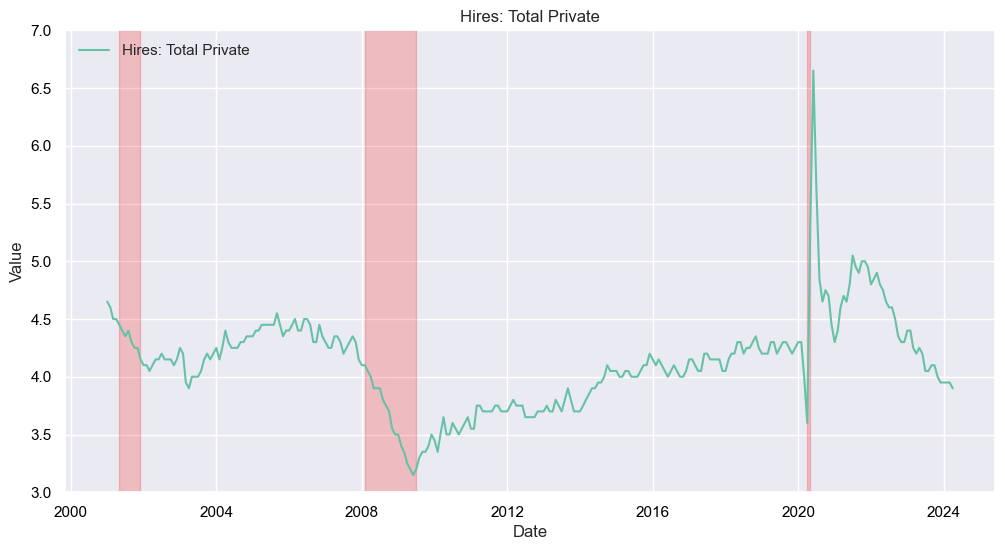

In [460]:
hires = ["JTS1000HIR"]
start = '2000-01-02'
end = dt.datetime.now()
hires1 = initial.dataframe(hires, data.set_index("DATE"), start, end)
hires1 = hires1.rename(columns = {"JTS1000HIR":"Hires: Total Private"})
eco_plot(hires1[['Hires: Total Private']].rolling(window=2).mean(), start, end, "Hires: Total Private", 3, 7, -62.5, 100, plot=True, save_fig=False)

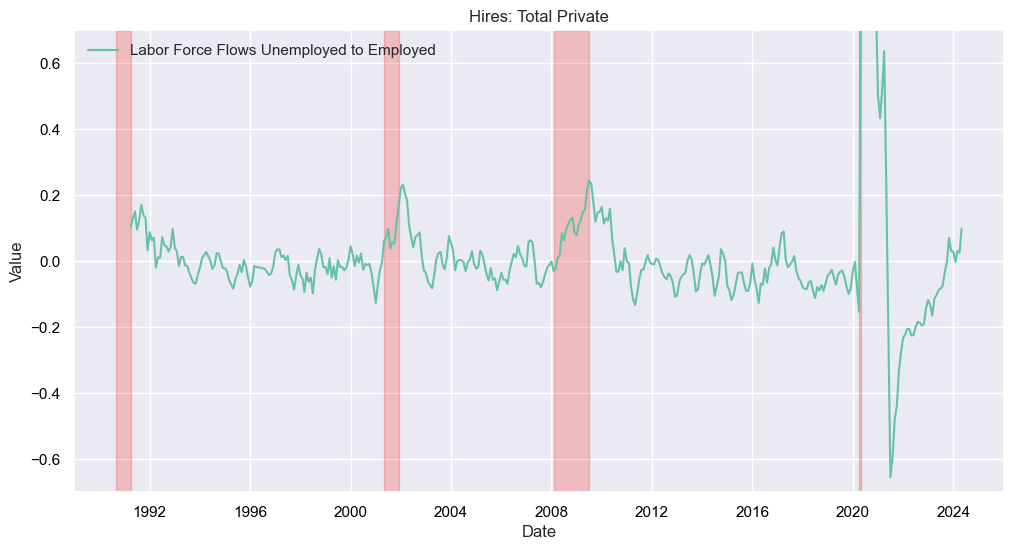

In [461]:
unemployment_to_employed = ["LNS17100000"]
start = '1990-01-02'
end = dt.datetime.now()
unemployment_to_employed1 = initial.dataframe(unemployment_to_employed, data.set_index("DATE"), start, end)
unemployment_to_employed1 = unemployment_to_employed1.rename(columns = {"LNS17100000":"Labor Force Flows Unemployed to Employed"})
unemployment_to_employed1 = ((unemployment_to_employed1 / unemployment_to_employed1.shift(12)))-1
eco_plot(unemployment_to_employed1.rolling(window=3).mean(), start, end, "Hires: Total Private", -.7, .7, -62.5, 100, plot=True, save_fig=False)

Other Indicators

In [462]:
churn = ["JTSTSL","JTS1000HIL","UNRATE","CLF16OV"]
start = '2000-01-02'
end = dt.datetime.now()
churn1 = initial.dataframe(churn, data.set_index("DATE"), start, end)
churn1['Churn'] = (churn1["JTSTSL"] + churn1["JTS1000HIL"]) / churn1["CLF16OV"]
churn1['Churn Rate (inverted)'] = (abs(churn1['Churn']-churn1['Churn'].max()))
churn1 = churn1.rolling(window=1).mean()['2000-01':'2020-01']
# eco_plot(churn1[['Churn Rate (inverted)',"UNRATE"]].rolling(window=1).mean(), start, end, "Churn Rate Deviating from Unemployment Rate", 3, 10, -62.5, 100, plot=True, save_fig=False)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=churn1.index, y=churn1['Churn Rate (inverted)'], name='Churn Rate (inverted)'),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=churn1.index, y=churn1['UNRATE'], name="Unemployment Rate (U3)"),
    secondary_y=True,)
fig.update_layout(
    title_text="Churn Rate Deviating from Unemployment Rate (2000-2020)",
    width=800,
    height=600)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Churn Rate</b> (inverted)", secondary_y=False)
fig.update_yaxes(title_text="<b>Unemployment Rate</b> U3", secondary_y=True)
fig.show()

In [463]:
churn = ["JTSTSL","JTS1000HIL","UNRATE","CLF16OV"]
start = '2000-01-02'
end = dt.datetime.now()
churn1 = initial.dataframe(churn, data.set_index("DATE"), start, end)
churn1['Churn'] = (churn1["JTSTSL"] + churn1["JTS1000HIL"]) / churn1["CLF16OV"]
churn1['Churn Rate (inverted)'] = (abs(churn1['Churn']-churn1['Churn'].max()))
churn1 = churn1.rolling(window=1).mean()['2021-01':]
# eco_plot(churn1[['Churn Rate (inverted)',"UNRATE"]].rolling(window=1).mean(), start, end, "Churn Rate Deviating from Unemployment Rate", 3, 10, -62.5, 100, plot=True, save_fig=False)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=churn1.index, y=churn1['Churn Rate (inverted)'], name='Churn Rate (inverted)'),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=churn1.index, y=churn1['UNRATE'], name="Unemployment Rate (U3)"),
    secondary_y=True,)
fig.update_layout(
    title_text="Churn Rate Deviating from Unemployment Rate (Post-Covid)",
    width=800,
    height=600)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Churn Rate</b> (inverted)", secondary_y=False)
fig.update_yaxes(title_text="<b>Unemployment Rate</b> U3", secondary_y=True)
fig.show()

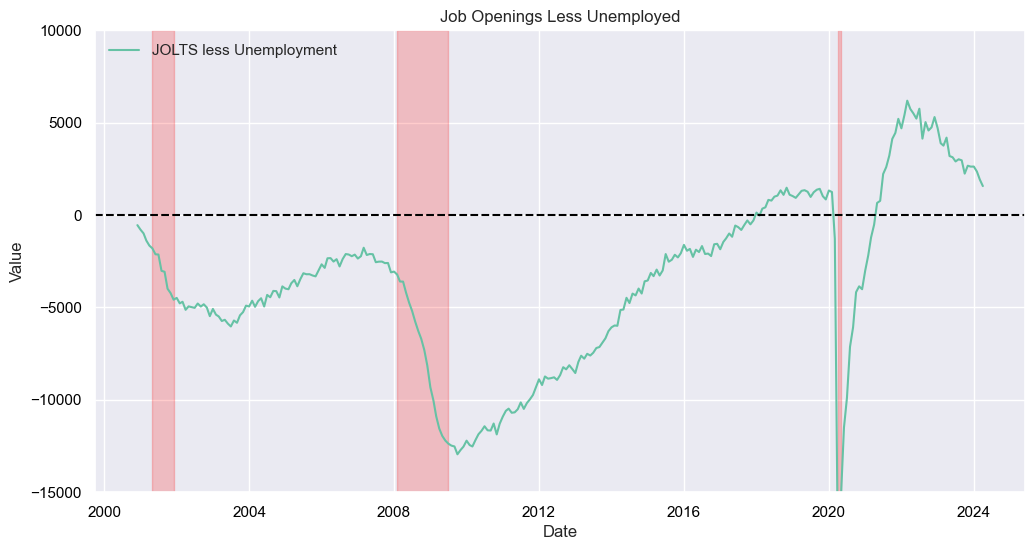

In [464]:
jolt_less_unemp = ["JTSJOL","UNEMPLOY"]
start = '2000-01-02'
end = dt.datetime.now()
jolt_less_unemp1 = initial.dataframe(jolt_less_unemp, data.set_index("DATE"), start, end)
jolt_less_unemp1['JOLTS less Unemployment'] = (jolt_less_unemp1['JTSJOL'] - jolt_less_unemp1['UNEMPLOY'])
eco_plot(jolt_less_unemp1[['JOLTS less Unemployment']], start, end, 'Job Openings Less Unemployed', -15000, 10000, 0.00, 1000000, plot=True, save_fig=False)

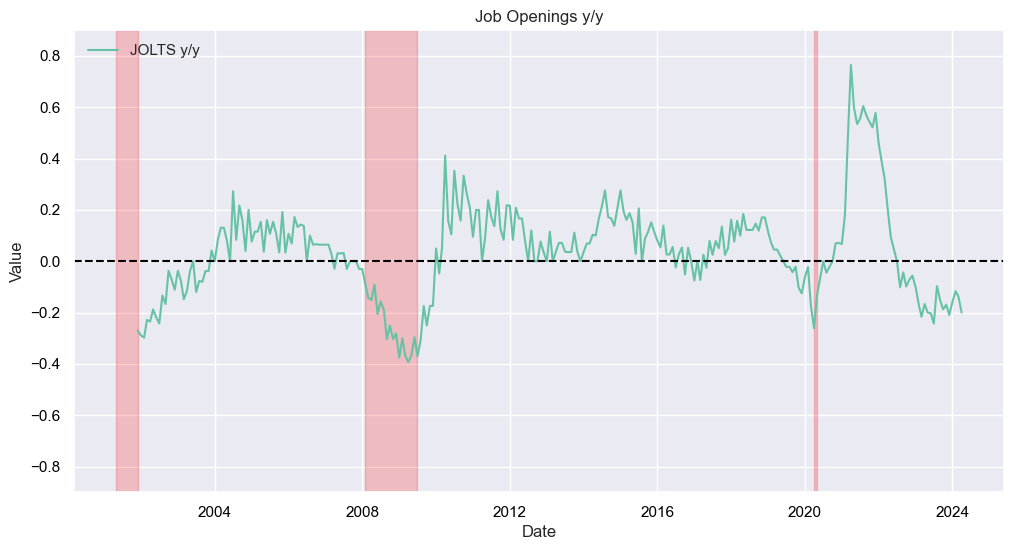

In [465]:
jolts = ["JTSJOR"]
start = '2000-01-02'
end = dt.datetime.now()
jolts_yoy = initial.dataframe(jolts, data.set_index("DATE"), start, end)
jolts_yoy['JOLTS y/y'] = (jolts_yoy['JTSJOR'] / jolts_yoy['JTSJOR'].shift(12))-1
eco_plot(jolts_yoy[['JOLTS y/y']], start, end, 'Job Openings y/y', -0.9, 0.9, 0.00, 1000, plot=True, save_fig=False)

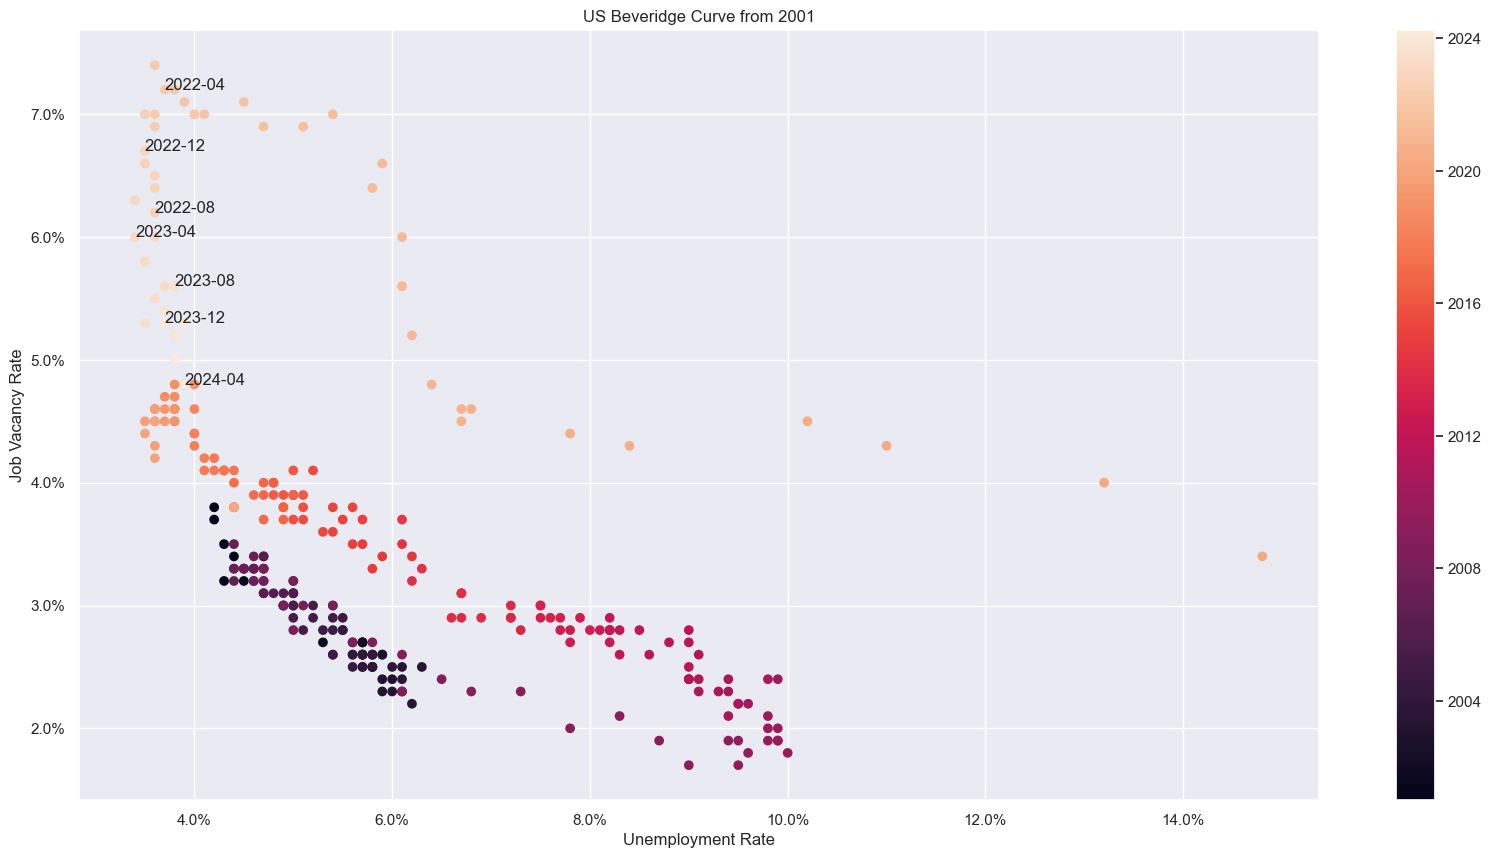

In [466]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
bvg_curve = ["UNRATE","JTSJOR"]
start = '2001-01-01'
end = dt.datetime.now()
bvg_curve1 = initial.dataframe(bvg_curve, data.set_index("DATE"), start, end)
bvg_curve_df = bvg_curve1[["UNRATE","JTSJOR"]].dropna()/100
bvg_curve_df = bvg_curve_df.rename(columns={"UNRATE":"Unemployment Rate", "JTSJOR":"Job Vacancy Rate"})
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(x=bvg_curve_df.iloc[:,0], y=bvg_curve_df.iloc[:,1], c=mdates.date2num(bvg_curve_df.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(bvg_curve_df.columns[0])
ax.set_ylabel(bvg_curve_df.columns[1])
ax.set_title('US Beveridge Curve from {:%Y}'.format(bvg_curve_df.index[0]))
for i in range(-1, -28, -4):
    plt.text(bvg_curve_df.iloc[i,0], bvg_curve_df.iloc[i,1], f'{bvg_curve_df.index[i]:%Y-%m}')
ax.grid(True)
loc = mdates.AutoDateLocator()
_ = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))

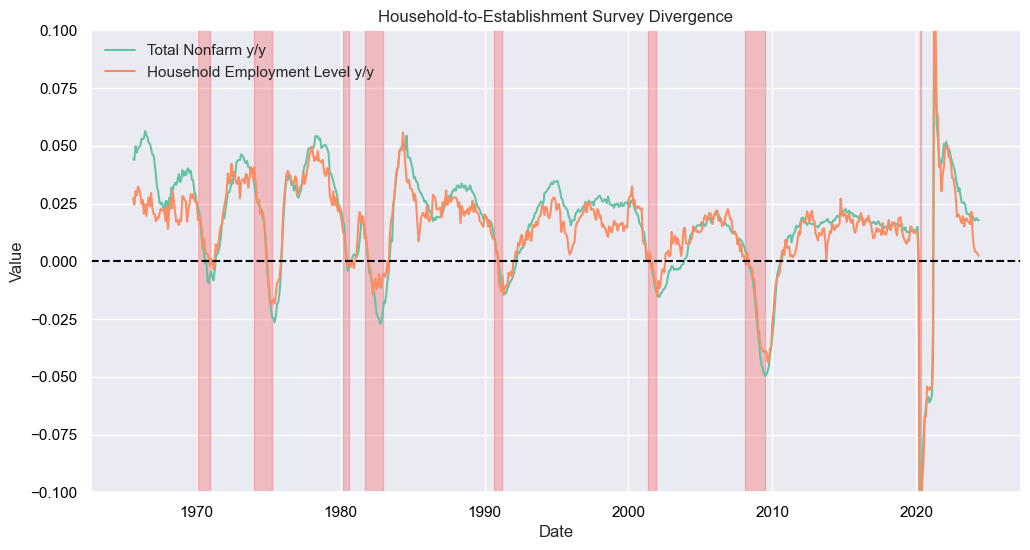

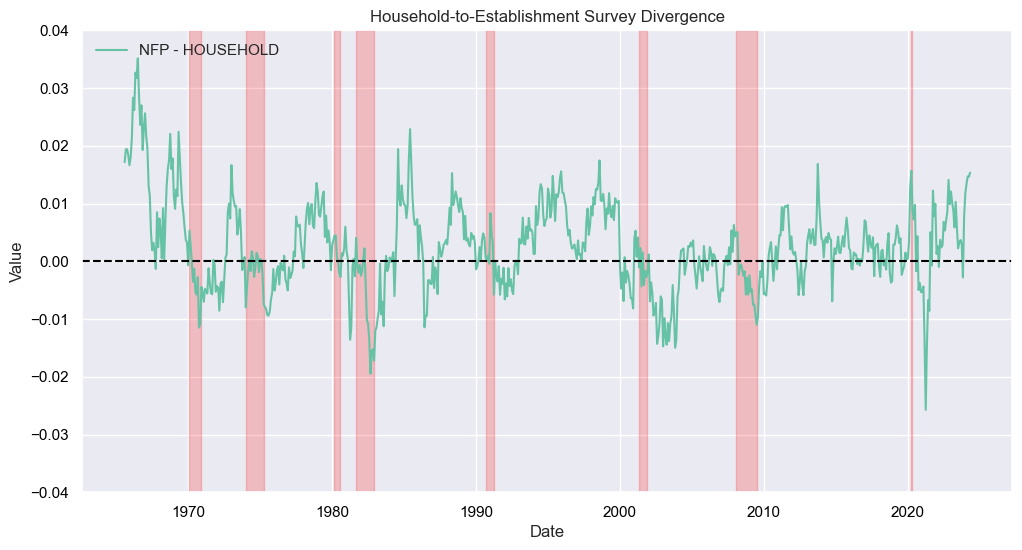

In [467]:
nfp_hshld = ['PAYEMS','CE16OV']
start = '1950-01-02'
end = dt.datetime.now()
payems = initial.dataframe(nfp_hshld, data.set_index("DATE"), start, end)
payems['Total Nonfarm y/y'] = (payems['PAYEMS'] / payems['PAYEMS'].shift(12))-1
payems['Household Employment Level y/y'] = (payems['CE16OV'] / payems['CE16OV'].shift(12))-1
payems['NFP - HOUSEHOLD'] = (payems['Total Nonfarm y/y'] - payems['Household Employment Level y/y'])
payems_yoy = payems[['Total Nonfarm y/y','Household Employment Level y/y','NFP - HOUSEHOLD']]
eco_plot(payems_yoy[['Total Nonfarm y/y','Household Employment Level y/y']], start, end, 'Household-to-Establishment Survey Divergence', -.1, .1, 0.00, 1000, plot=True, save_fig=False)
eco_plot(payems_yoy[['NFP - HOUSEHOLD']], start, end, 'Household-to-Establishment Survey Divergence', -0.04, 0.04, 0.00, 1000, plot=True, save_fig=False)

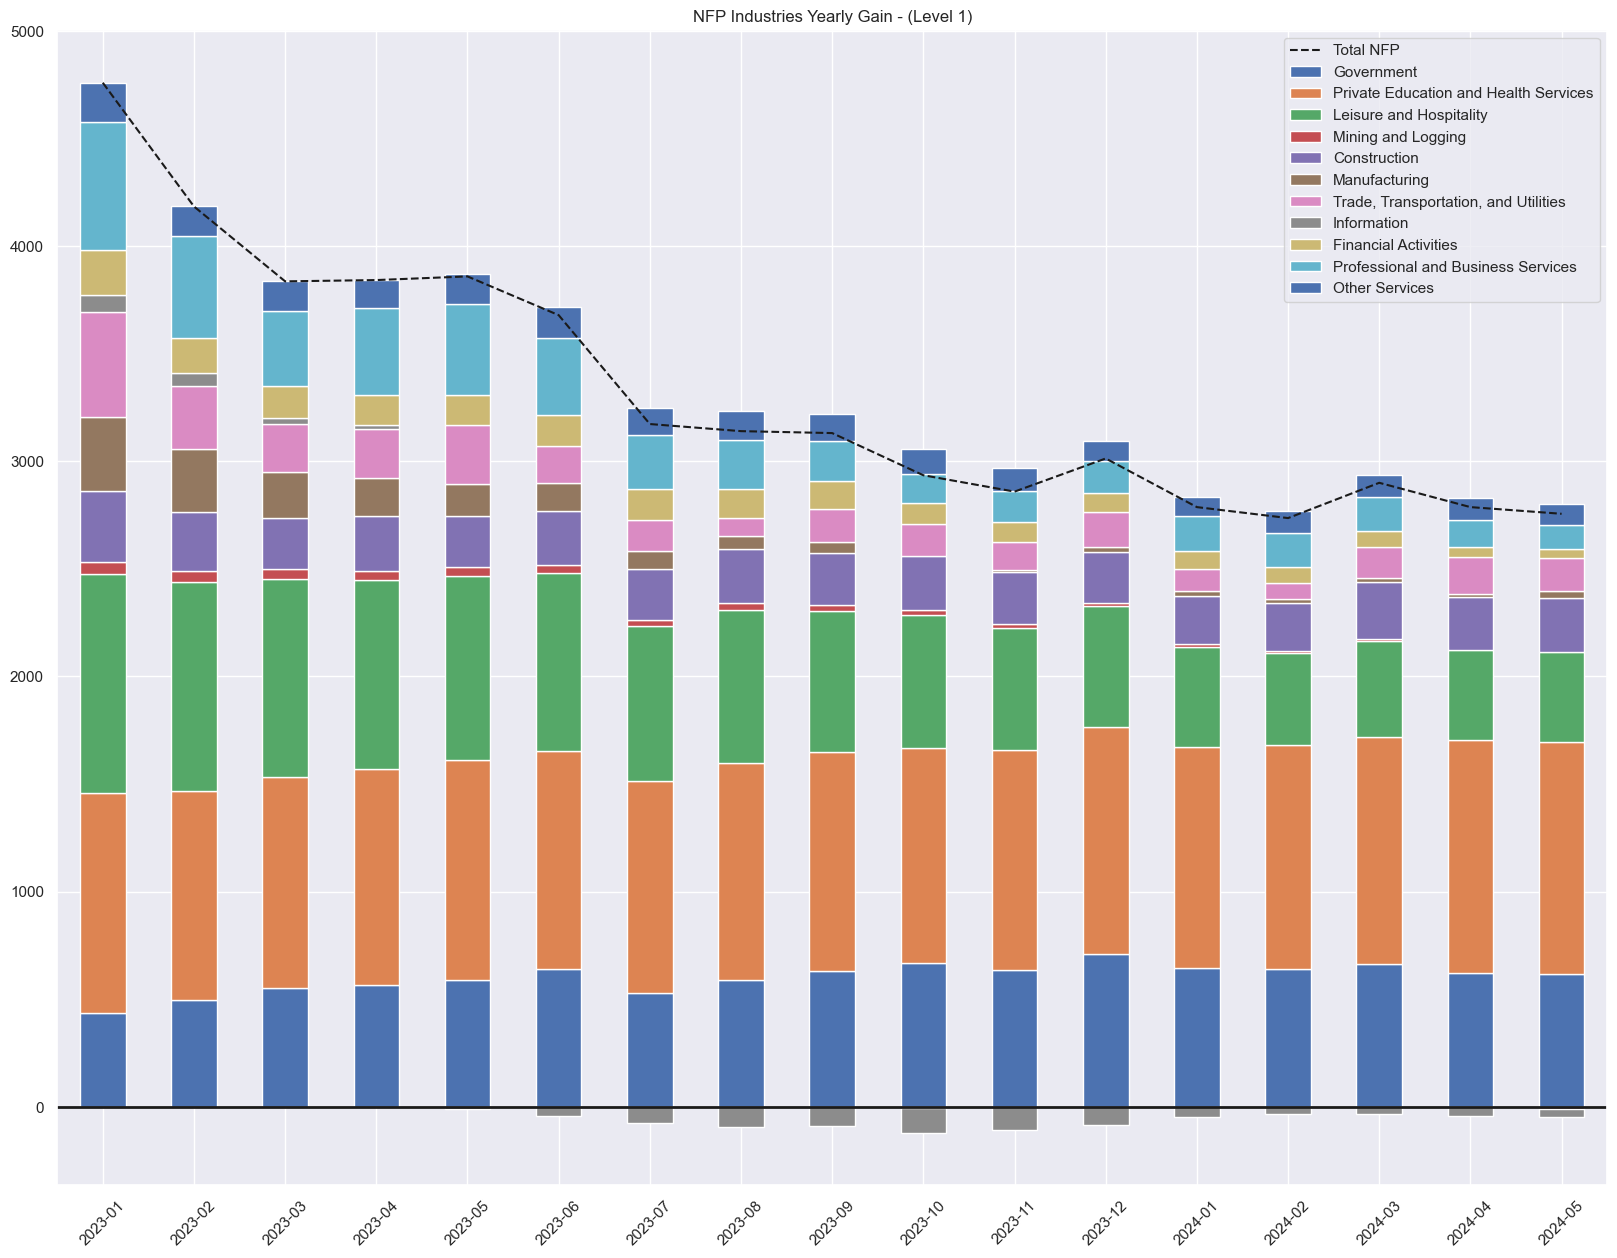

In [468]:
level1 = ['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']
start = '1950-01-02'
end = dt.datetime.now()
level1 = initial.dataframe(level1, data.set_index("DATE"), start, end)
level1_recent = level1[['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']]
# level1_recent = ((level1_recent / level1_recent.shift(12))-1)['2023-01-01':]*100
level1_recent = ((level1_recent - level1_recent.shift(12)))['2023-01-01':]
level1_recent = level1_recent.rename(columns={ "PAYEMS":"Total NFP",
                                "USGOVT":"Government",
                                "USEHS":"Private Education and Health Services",
                                "USLAH":"Leisure and Hospitality",
                                "USMINE":"Mining and Logging",
                                "USCONS":"Construction",
                                "MANEMP":"Manufacturing",
                                "USTPU":"Trade, Transportation, and Utilities",
                                "USINFO":"Information",
                                "USFIRE":"Financial Activities",
                                "USPBS":"Professional and Business Services",
                                "USSERV":"Other Services"})
ax = level1_recent.iloc[:,0].plot(figsize=(20,15), grid = False, title = "NFP Industries Yearly Gain - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
level1_recent.iloc[:,1:].plot.bar(ax=ax, stacked=True, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, level1_recent.index)))

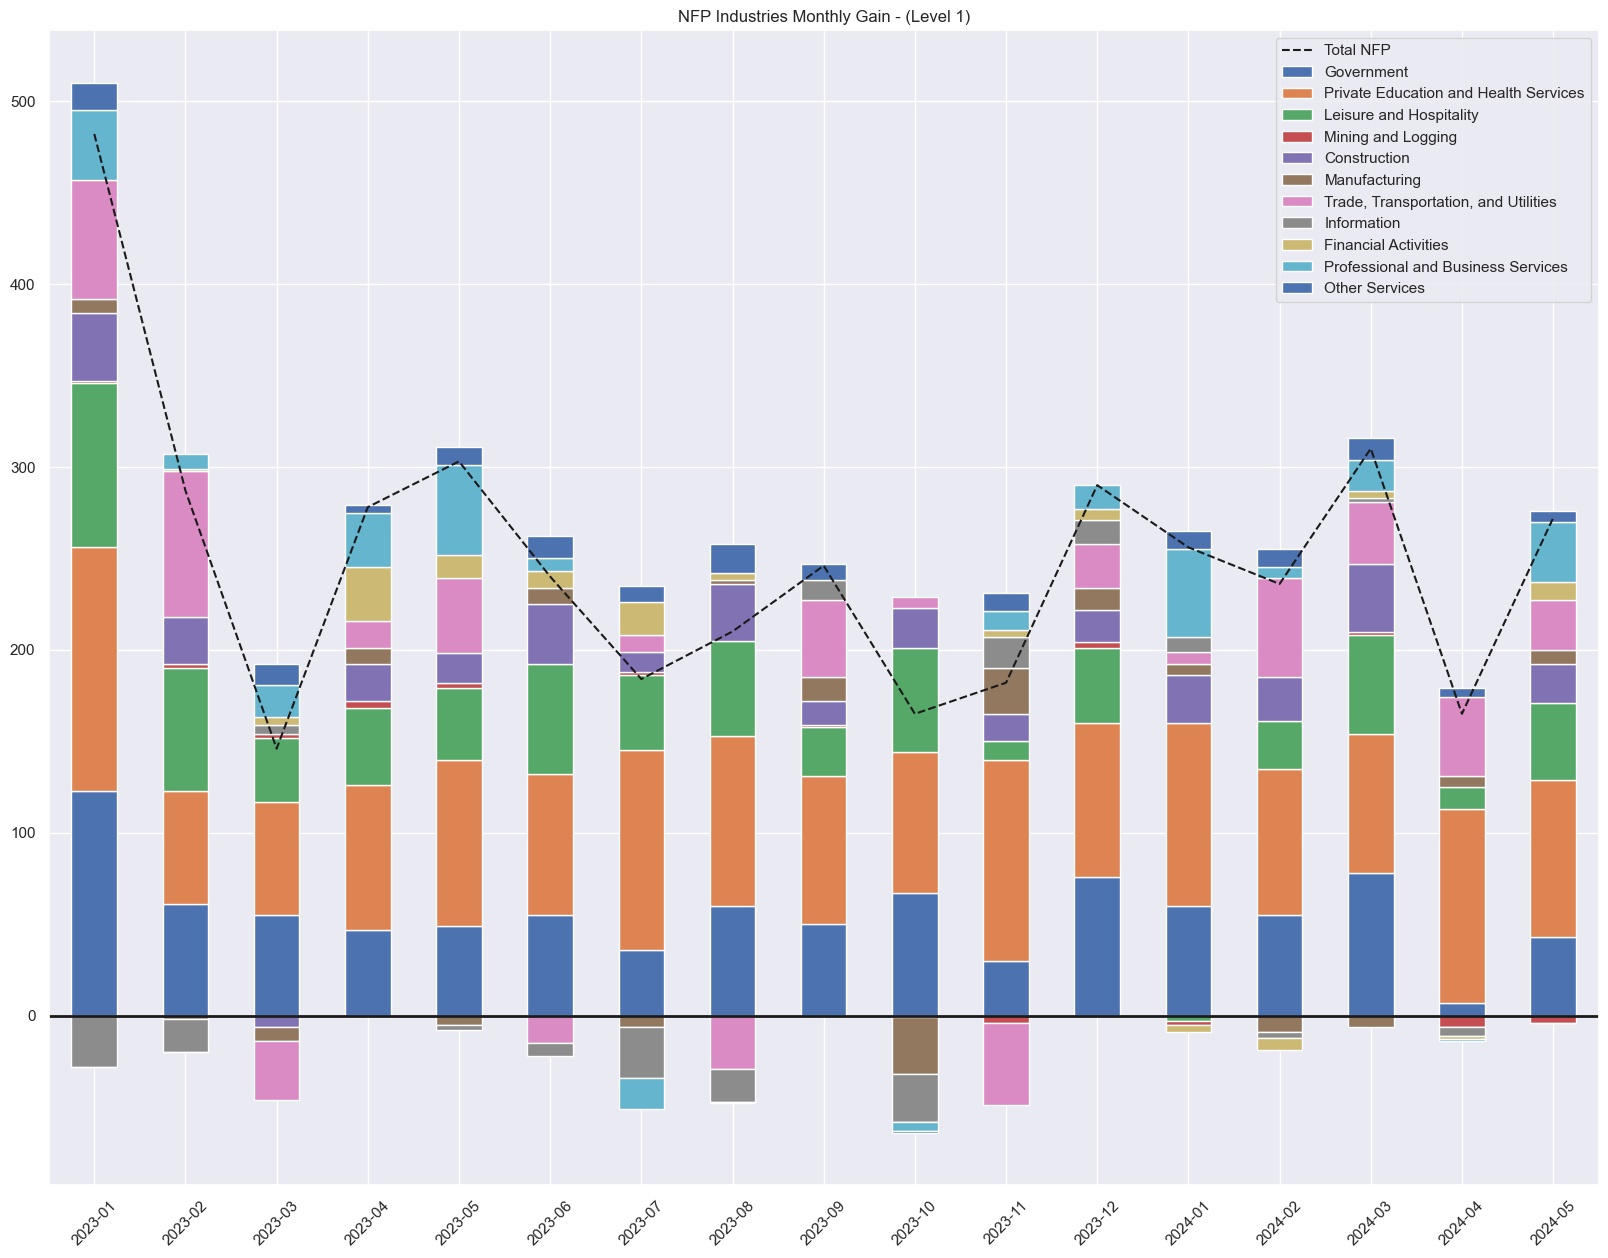

In [469]:
level1 = ['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']
start = '1950-01-02'
end = dt.datetime.now()
level1 = initial.dataframe(level1, data.set_index("DATE"), start, end)
level1_recent = level1[['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']]
level1_recent = ((level1_recent - level1_recent.shift(1)))['2023-01-01':]
level1_recent = level1_recent.rename(columns={ "PAYEMS":"Total NFP",
                                "USGOVT":"Government",
                                "USEHS":"Private Education and Health Services",
                                "USLAH":"Leisure and Hospitality",
                                "USMINE":"Mining and Logging",
                                "USCONS":"Construction",
                                "MANEMP":"Manufacturing",
                                "USTPU":"Trade, Transportation, and Utilities",
                                "USINFO":"Information",
                                "USFIRE":"Financial Activities",
                                "USPBS":"Professional and Business Services",
                                "USSERV":"Other Services"})
ax = level1_recent.iloc[:,0].plot(figsize=(20,15), grid = False, title = "NFP Industries Monthly Gain - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
level1_recent.iloc[:,1:].plot.bar(ax=ax, stacked=True, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, level1_recent.index)))

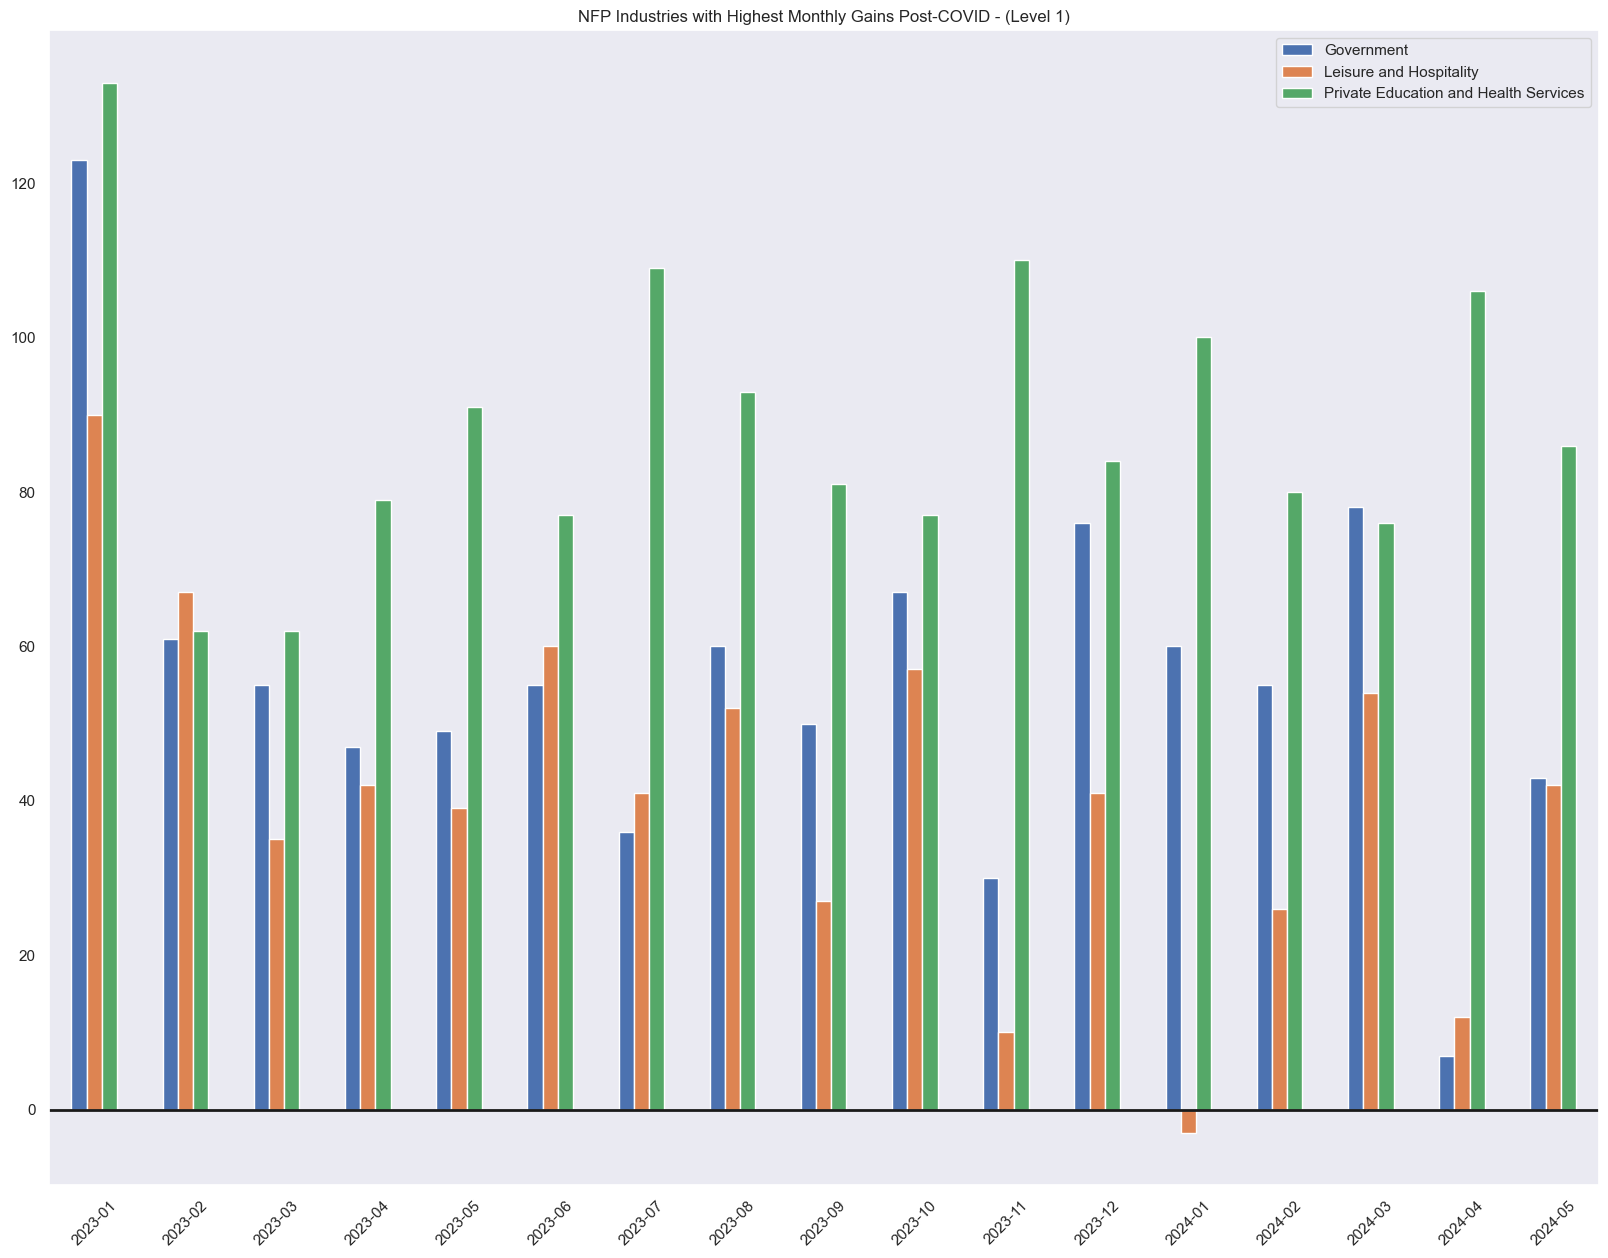

In [470]:
level1 = ['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']
start = '1950-01-02'
end = dt.datetime.now()
level1 = initial.dataframe(level1, data.set_index("DATE"), start, end)
level1_recent = level1[['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']]
level1_recent = ((level1_recent - level1_recent.shift(1)))['2023-01-01':]
level1_recent = level1_recent.rename(columns={ "PAYEMS":"Total NFP",
                                "USGOVT":"Government",
                                "USEHS":"Private Education and Health Services",
                                "USLAH":"Leisure and Hospitality",
                                "USMINE":"Mining and Logging",
                                "USCONS":"Construction",
                                "MANEMP":"Manufacturing",
                                "USTPU":"Trade, Transportation, and Utilities",
                                "USINFO":"Information",
                                "USFIRE":"Financial Activities",
                                "USPBS":"Professional and Business Services",
                                "USSERV":"Other Services"})
level1_recent = level1_recent[['Government','Leisure and Hospitality','Private Education and Health Services']]
ax = level1_recent.plot.bar(title = "NFP Industries with Highest Monthly Gains Post-COVID - (Level 1)", figsize=(20,15), 
                       stacked=False, grid=False, xlabel='', rot=45, use_index = True)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, level1_recent.index)))

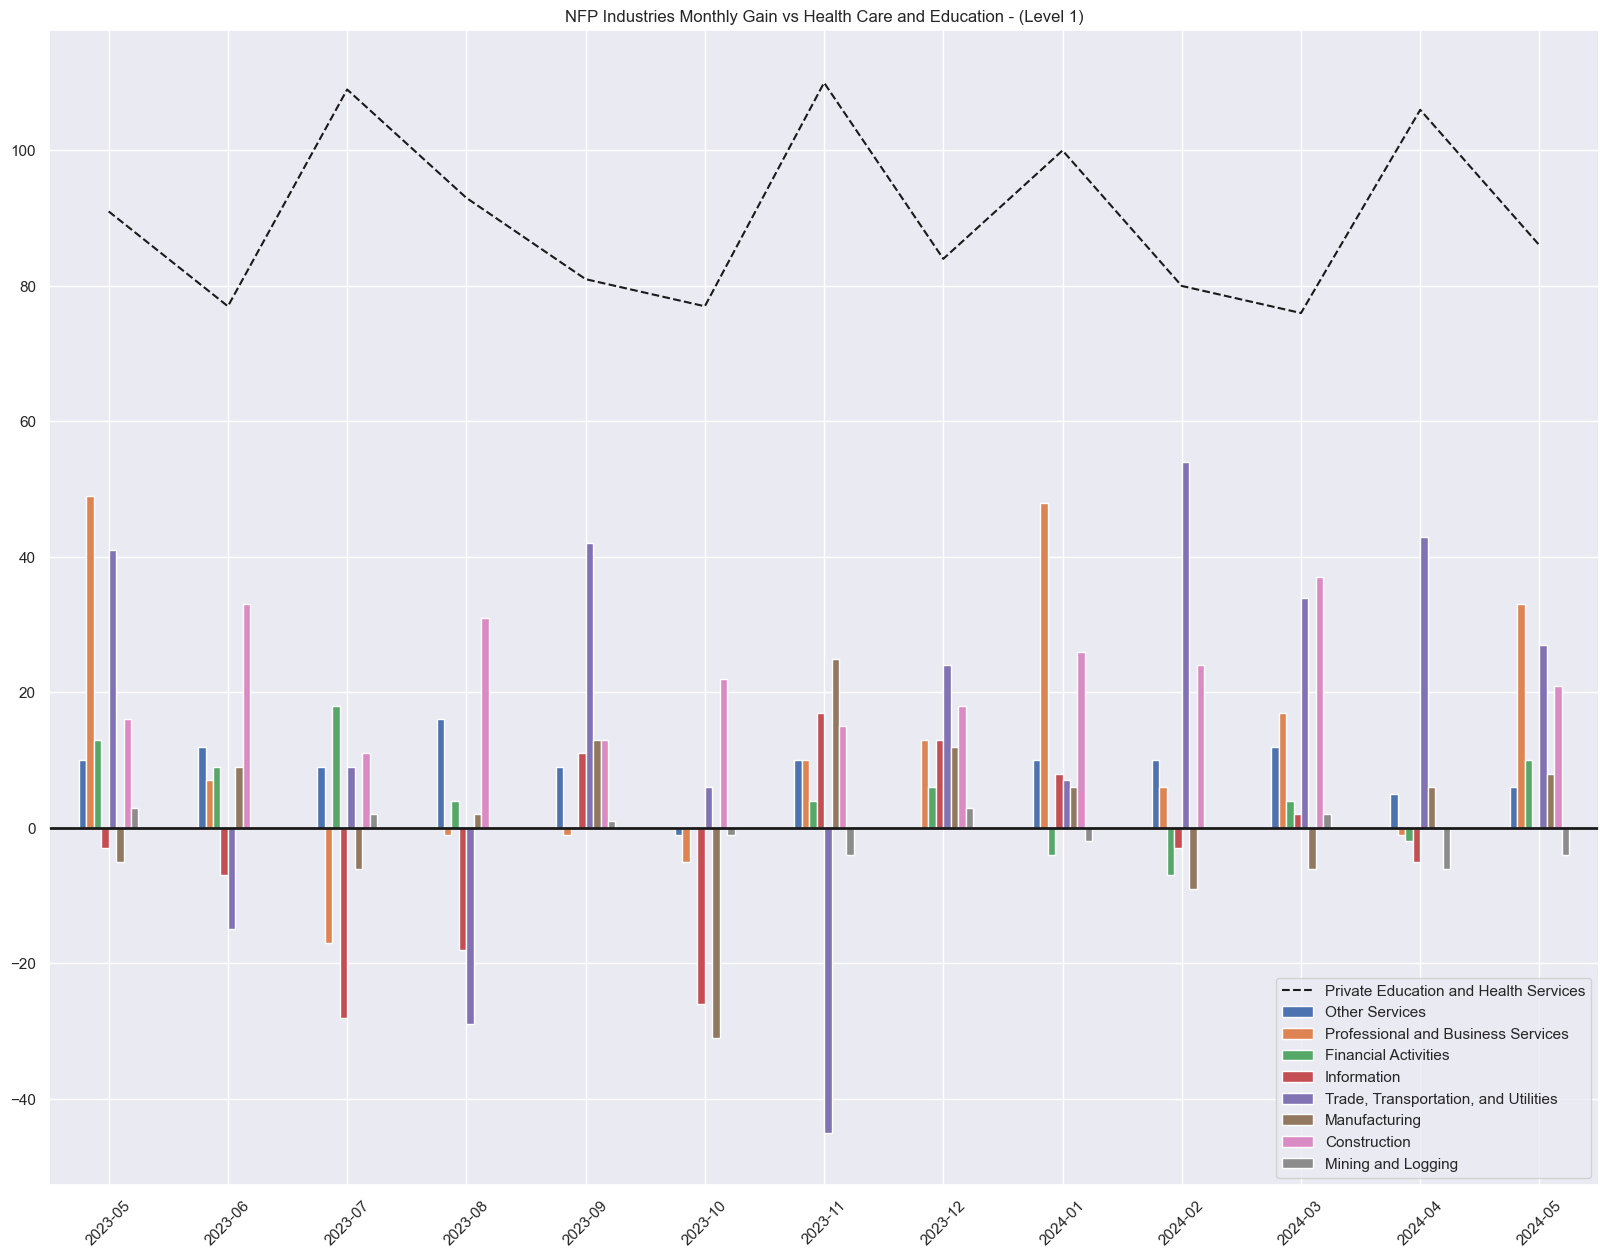

In [471]:
level1 = ['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']
start = '1950-01-02'
end = dt.datetime.now()
level1 = initial.dataframe(level1, data.set_index("DATE"), start, end)
level1_recent = level1[['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']]
level1_recent = ((level1_recent - level1_recent.shift(1)))['2023-05-01':]
level1_recent = level1_recent.rename(columns={ "PAYEMS":"Total NFP",
                                "USGOVT":"Government",
                                "USEHS":"Private Education and Health Services",
                                "USLAH":"Leisure and Hospitality",
                                "USMINE":"Mining and Logging",
                                "USCONS":"Construction",
                                "MANEMP":"Manufacturing",
                                "USTPU":"Trade, Transportation, and Utilities",
                                "USINFO":"Information",
                                "USFIRE":"Financial Activities",
                                "USPBS":"Professional and Business Services",
                                "USSERV":"Other Services"})
level1_recent = level1_recent[['Private Education and Health Services','Other Services','Professional and Business Services','Financial Activities','Information','Trade, Transportation, and Utilities',
                               'Manufacturing','Construction','Mining and Logging']]
ax = level1_recent.iloc[:,0].plot(figsize=(20,15), grid = False, title = "NFP Industries Monthly Gain vs Health Care and Education - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
level1_recent.iloc[:,1:].plot.bar(ax=ax, stacked=False, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, level1_recent.index)))

Average Hourly Earnings and PCE Services Correlation

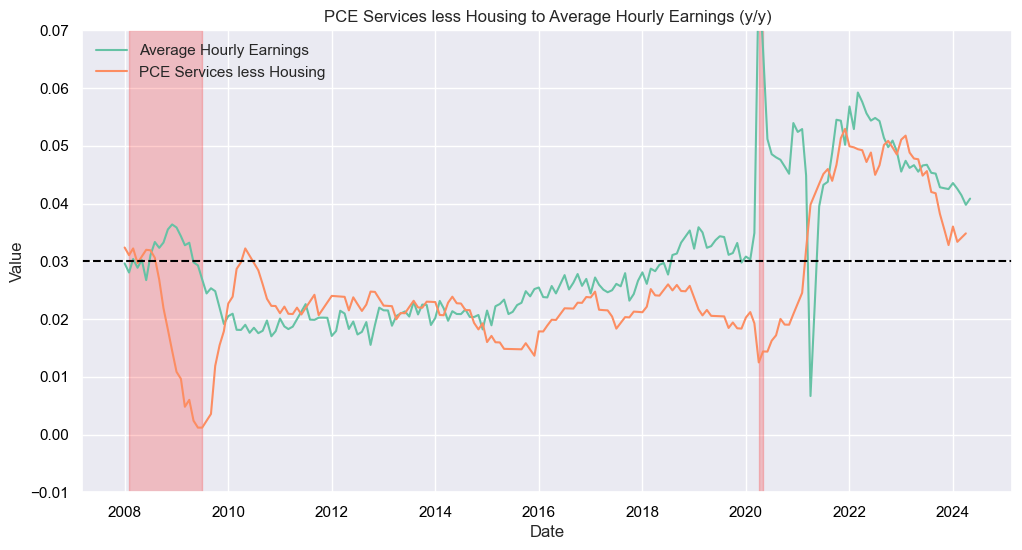

In [472]:
all = ['CES0500000003','IA001260M']
start = '2007-01-01'
end = dt.datetime.now()
he = initial.dataframe(all, data.set_index("DATE"), start, end)#.fillna(method='ffill')
he_yoy = ((he / he.shift(12)) - 1)
he_yoy = he_yoy.rename(columns = {'CES0500000003':'Average Hourly Earnings','IA001260M':'PCE Services less Housing'})
eco_plot(he_yoy, '2007-01-01', end, 'PCE Services less Housing to Average Hourly Earnings (y/y)', -0.01, 0.07, 0.03, 100, plot=True, save_fig=False)

Average Hourly Earnings (YoY)

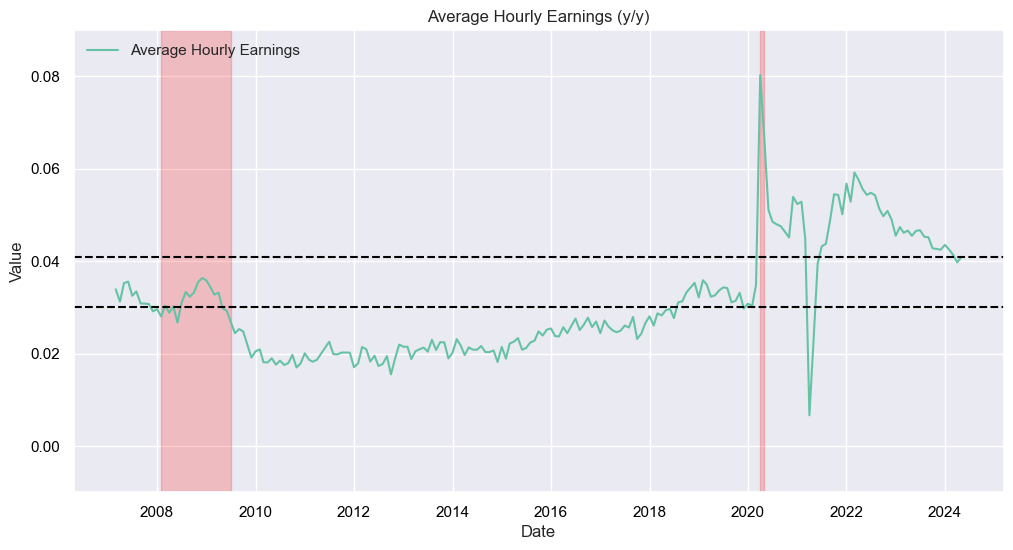

In [473]:
ahe = ['CES0500000003']
start = '1970-01-02'
end = dt.datetime.now()
he = initial.dataframe(ahe, data.set_index("DATE"), start, end).fillna(method='ffill')
he_yoy = ((he / he.shift(12)) - 1).dropna()
he_yoy.columns = ['Average Hourly Earnings']
eco_plot(he_yoy, '2005-01-01', end, 'Average Hourly Earnings (y/y)', -0.01, 0.09, 0.03, 0.041,plot=True, save_fig=False)

Average Hourly Earnings (6 Month Annualized)

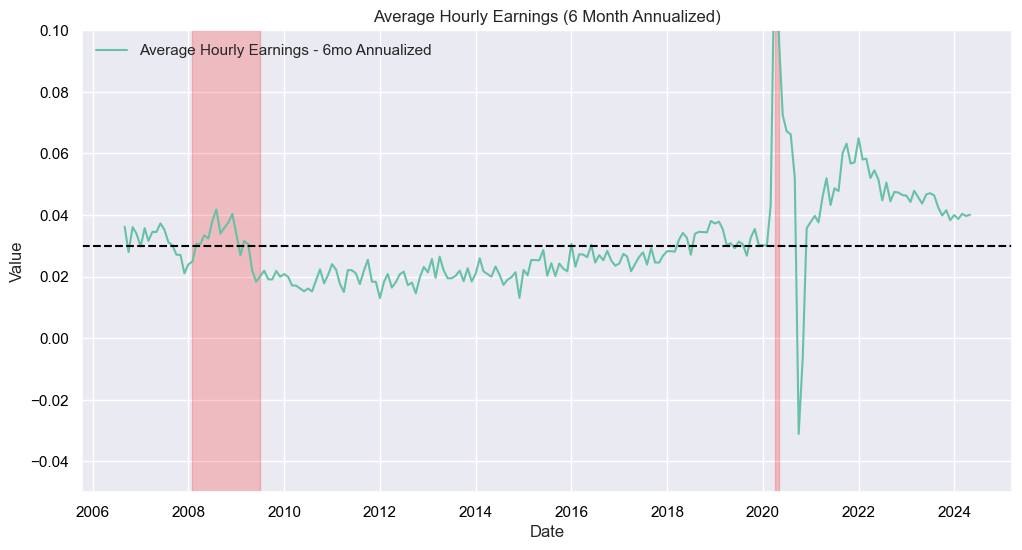

In [474]:
ahe = ['CES0500000003']
start = '1970-01-02'
end = dt.datetime.now()
he = initial.dataframe(ahe, data.set_index("DATE"), start, end).fillna(method='ffill')
he3mo = ((he / he.shift(6))**(12/6) - 1).dropna()
he3mo.columns = ['Average Hourly Earnings - 6mo Annualized']
eco_plot(he3mo, '2005-01-01', end, 'Average Hourly Earnings (6 Month Annualized)', -0.05, 0.1, 0.03, 100, plot=True, save_fig=False)

Average Hourly Earnings (3 Month Annualized)

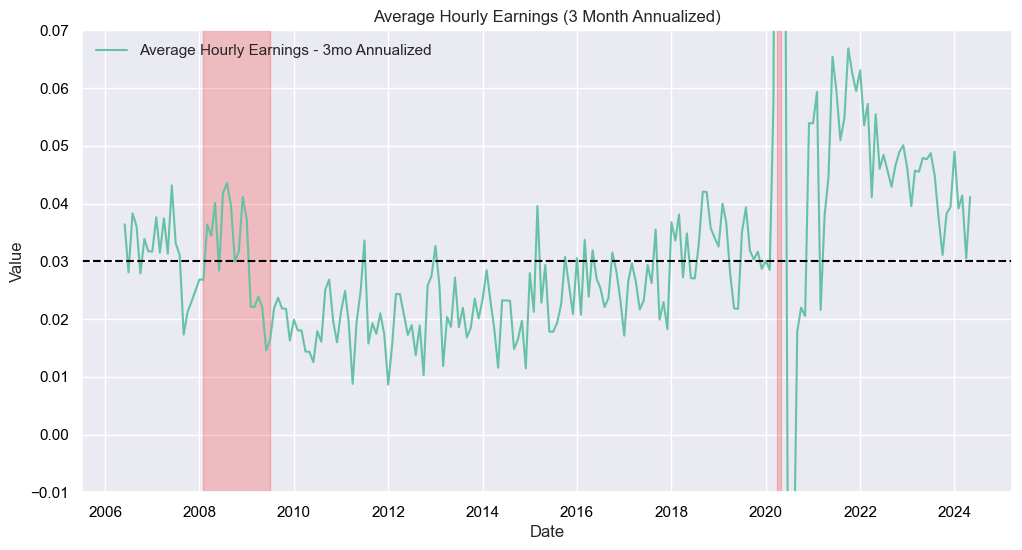

In [475]:
ahe = ['CES0500000003']
start = '1970-01-02'
end = dt.datetime.now()
he = initial.dataframe(ahe, data.set_index("DATE"), start, end).fillna(method='ffill')
he3mo = ((he / he.shift(3))**(12/3) - 1).dropna()
he3mo.columns = ['Average Hourly Earnings - 3mo Annualized']
eco_plot(he3mo, '2005-01-01', end, 'Average Hourly Earnings (3 Month Annualized)', -0.01, 0.07, 0.03, 100, plot=True, save_fig=False)

Unit Labor Costs to CPI

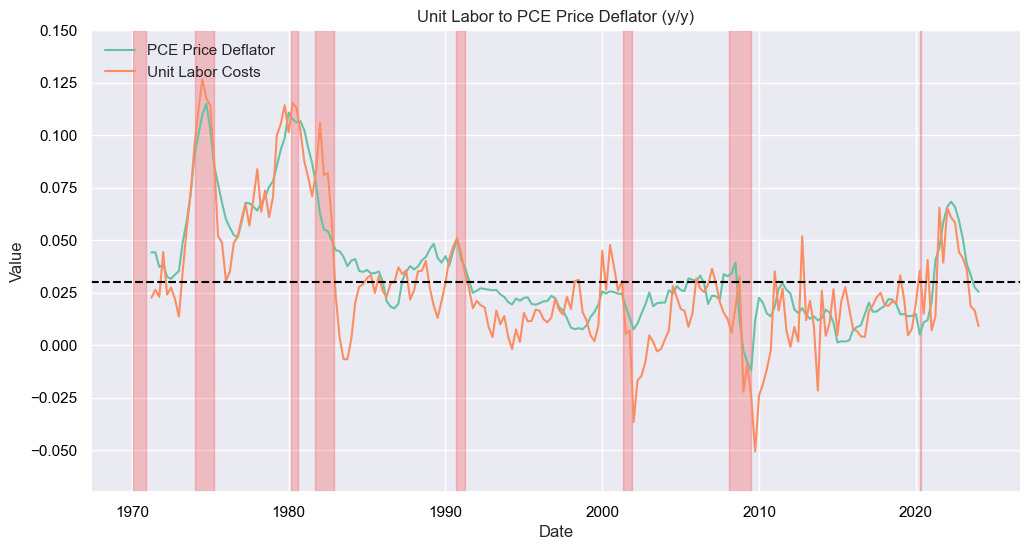

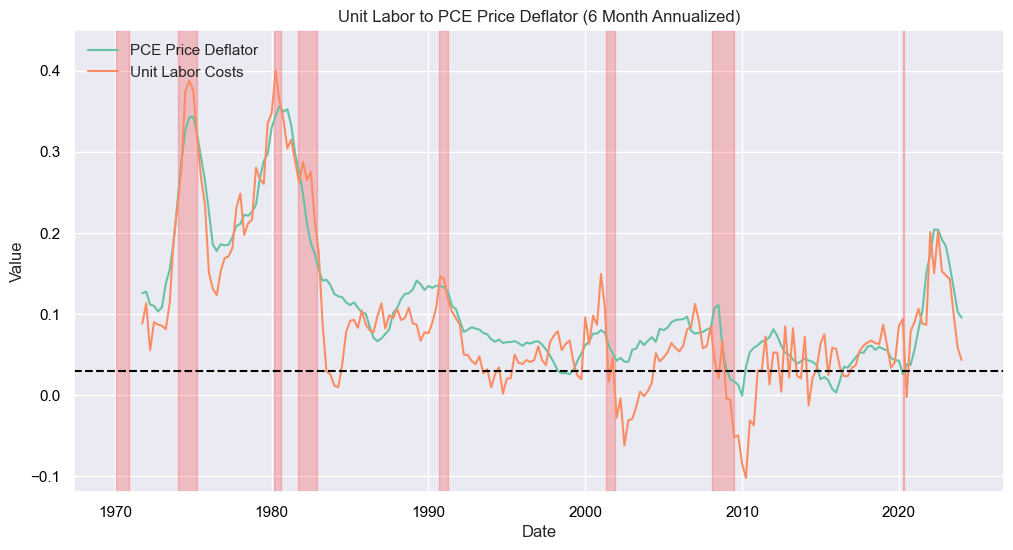

In [479]:
unit_labor = ["ULCNFB","DPCERD3Q086SBEA"] 
start = '1970-01-02'
end = dt.datetime.now()
unit_labor1 = initial.dataframe(unit_labor, data.set_index("DATE"), start, end).fillna(method='ffill')
unit_labor1 = unit_labor1.rename(columns = {"ULCNFB":"Unit Labor Costs","DPCERD3Q086SBEA":"PCE Price Deflator"})
unit_labor2 = (unit_labor1 / unit_labor1.shift(4))-1
unit_labor3mo = ((unit_labor1 / unit_labor1.shift(6))**(12/6) - 1).dropna()
eco_plot(unit_labor2, start, end, 'Unit Labor to PCE Price Deflator (y/y)',-.07, .15, 0.03, 100, plot=True, save_fig=False)
eco_plot(unit_labor3mo, start, end, 'Unit Labor to PCE Price Deflator (6 Month Annualized)',-.12, .45, 0.03, 100, plot=True, save_fig=False)

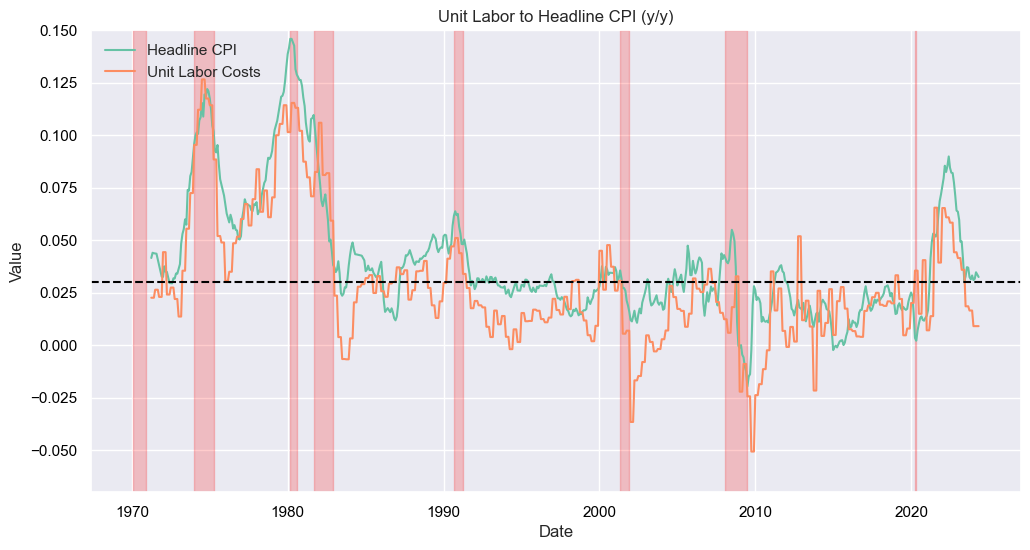

In [501]:
unit_labor = ["ULCNFB","CPIAUCSL"] 
start = '1970-01-02'
end = dt.datetime.now()
unit_labor1 = initial.dataframe(unit_labor, data.set_index("DATE"), start, end)
unit_labor1 = unit_labor1.rename(columns = {"ULCNFB":"Unit Labor Costs","CPIAUCSL":"Headline CPI"})
cpi = unit_labor1[['Headline CPI']].dropna()
cpi = (cpi / cpi.shift(12))-1
ul = unit_labor1[['Unit Labor Costs']].dropna() 
ul1 = (ul / ul.shift(4))-1
ul_to_cpi = pd.concat([cpi, ul1],axis=1).fillna(method='ffill').dropna()
eco_plot(ul_to_cpi, start, end, 'Unit Labor to Headline CPI (y/y)',-.07, .15, 0.03, 100, plot=True, save_fig=False)

Earned Income Proxy

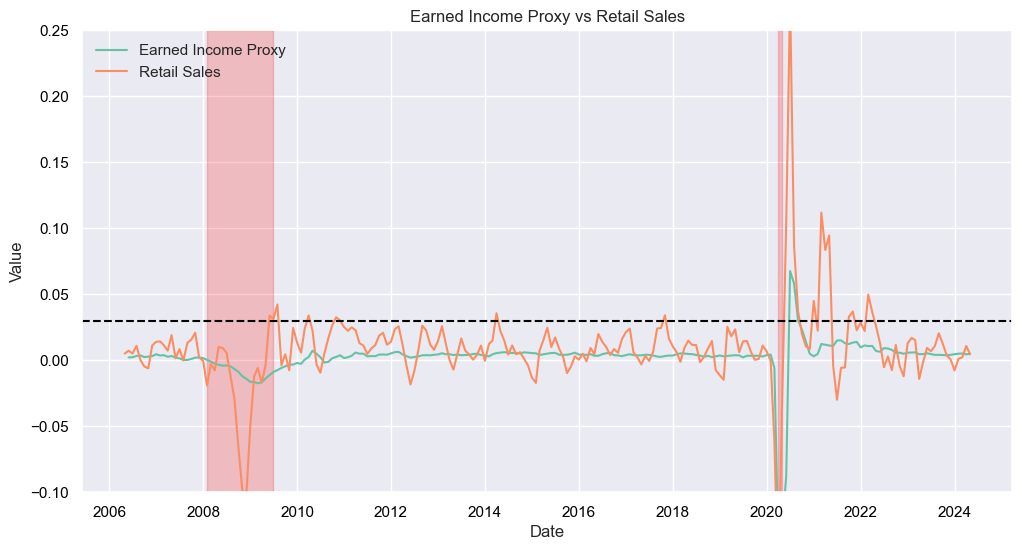

In [491]:
earned_income_proxy = ["PAYEMS","AWHAETP","CES0500000003","RSXFS","A132RC1Q027SBEA"]
start = '2006-01-02'
end = dt.datetime.now()
earned_income_proxy1 = initial.dataframe(earned_income_proxy, data.set_index("DATE"), start, end).fillna(method='ffill')
earned_income_proxy1['Earned Income Proxy'] = (earned_income_proxy1['PAYEMS'] + earned_income_proxy1['AWHAETP'] + earned_income_proxy1['CES0500000003'])*52
earned_income_proxy1 = (earned_income_proxy1 / earned_income_proxy1.shift(3))-1
earned_income_proxy1 = earned_income_proxy1.rename(columns={"RSXFS":"Retail Sales"})
eco_plot(earned_income_proxy1[['Earned Income Proxy','Retail Sales']], '2005-01-01', end, 'Earned Income Proxy vs Retail Sales', -0.1, 0.25, 0.03, 100, plot=True, save_fig=False)

Phillips Curve

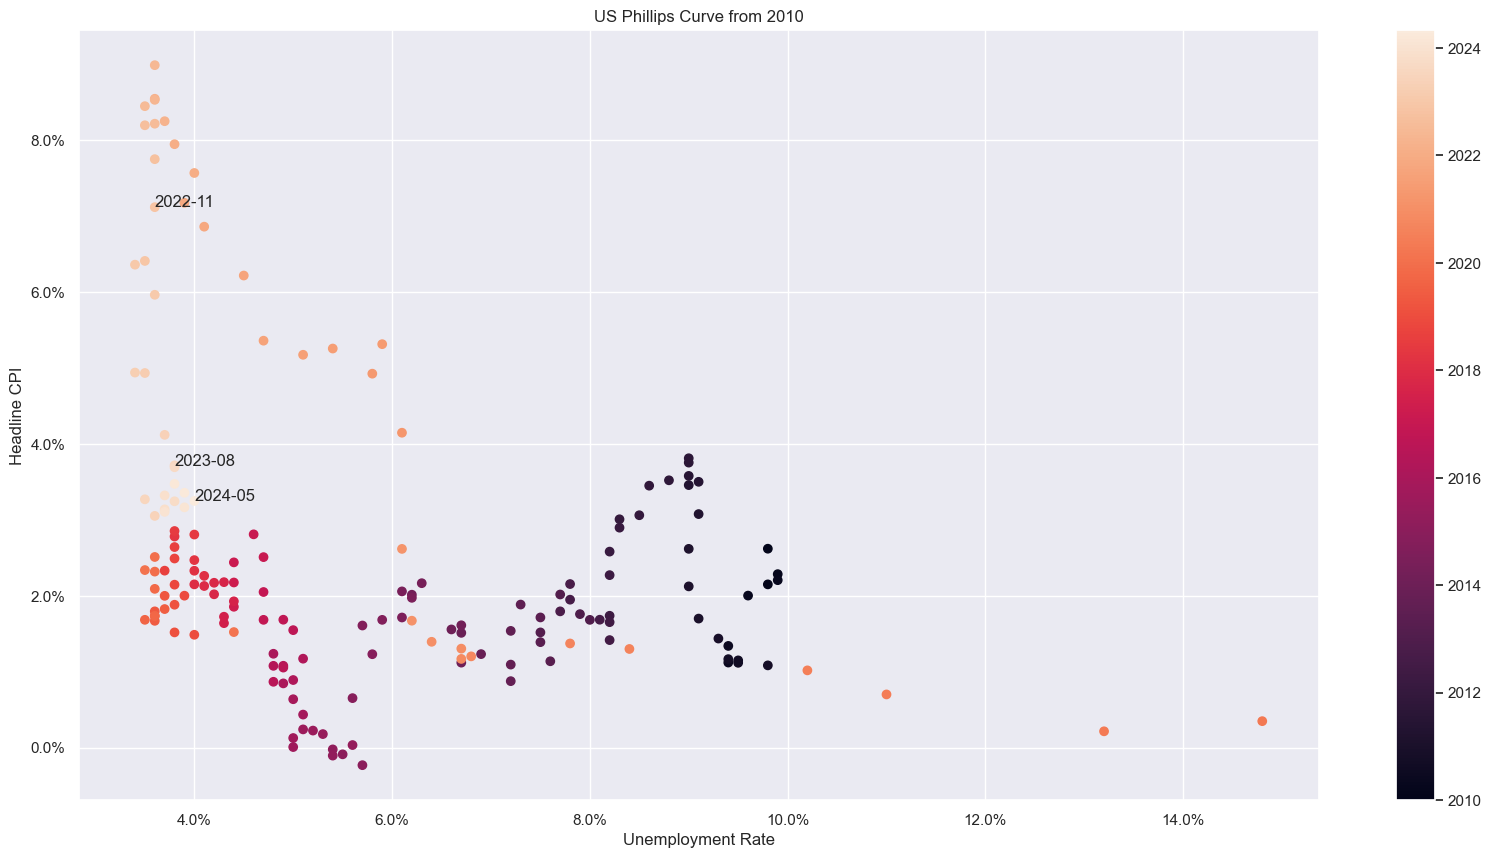

In [557]:
pc = ["UNRATE","CPIAUCSL"]
start = '1950-01-01'
end = dt.datetime.now()
pc1 = initial.dataframe(pc, data.set_index("DATE"), start, end)
pc1['CPI'] = (pc1['CPIAUCSL'] / pc1['CPIAUCSL'].shift(12))-1
pc1['UNRATE'] = (pc1['UNRATE'].dropna())/100
pc_df = pc1[["UNRATE","CPI"]].dropna()
pc_df = pc_df.rename(columns={"UNRATE":"Unemployment Rate", "CPI":"Headline CPI"})
pc_df1 = pc_df['2010':]
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(x=pc_df1.iloc[:,0], y=pc_df1.iloc[:,1], c=mdates.date2num(pc_df1.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel(pc_df1.columns[0])
ax.set_ylabel(pc_df1.columns[1])
ax.set_title("US Phillips Curve from {:%Y}".format(pc_df1.index[0]))
for i in range(-1, -27, -9):
    plt.text(pc_df1.iloc[i,0], pc_df1.iloc[i,1], f'{pc_df1.index[i]:%Y-%m}')
ax.grid(True)
loc = mdates.AutoDateLocator()
_ = fig.colorbar(sc, ticks=loc, format=mdates.AutoDateFormatter(loc))

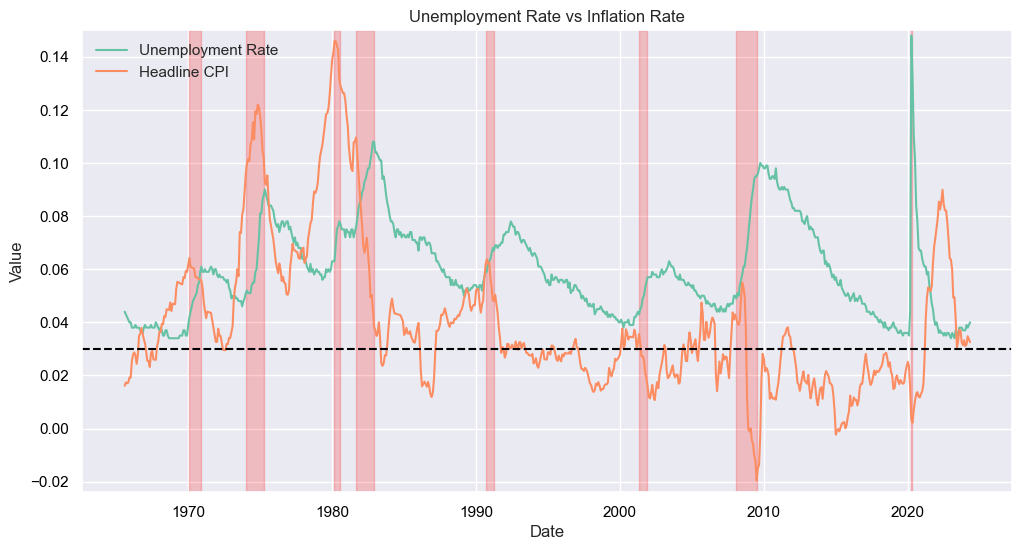

In [519]:
start='1950-01-01'
eco_plot(pc_df, start, end, "Unemployment Rate vs Inflation Rate", -0.024, 0.15, 0.03, 100, plot=True, save_fig=False)

Nonfarm Payrolls

<Axes: title={'center': 'NFP Gains by Sector'}, xlabel='ticker'>

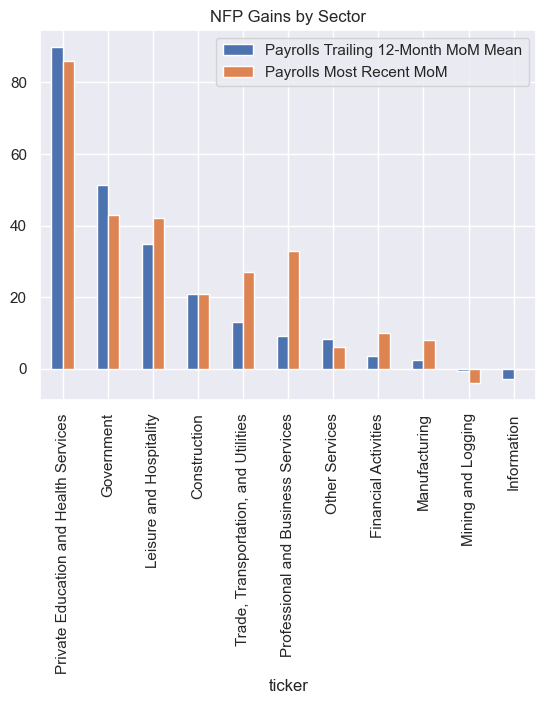

In [558]:
level1 = ['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']
start = '1950-01-02'
end = dt.datetime.now()
level1 = initial.dataframe(level1, data.set_index("DATE"), start, end)
level1_recent = level1[['PAYEMS','USGOVT','USEHS','USLAH','USMINE','USCONS','MANEMP','USTPU','USINFO','USFIRE','USPBS','USSERV']]
level1_recent = ((level1_recent - level1_recent.shift(1)))['2023-06-01':]
level1_recent = level1_recent.rename(columns={ "PAYEMS":"Total NFP",
                                "USGOVT":"Government",
                                "USEHS":"Private Education and Health Services",
                                "USLAH":"Leisure and Hospitality",
                                "USMINE":"Mining and Logging",
                                "USCONS":"Construction",
                                "MANEMP":"Manufacturing",
                                "USTPU":"Trade, Transportation, and Utilities",
                                "USINFO":"Information",
                                "USFIRE":"Financial Activities",
                                "USPBS":"Professional and Business Services",
                                "USSERV":"Other Services"})
level1_recent = level1_recent[['Government',
       'Private Education and Health Services',
       'Leisure and Hospitality', 'Mining and Logging',
       'Construction', 'Manufacturing',
       'Trade, Transportation, and Utilities', 'Information',
       'Financial Activities',
       'Professional and Business Services', 'Other Services']]
level1_monthly_mean = level1_recent.mean().sort_values(ascending=False)
level1_monthly_mean = pd.DataFrame([level1_monthly_mean]).T
level1_monthly_mean.columns = ["Payrolls Trailing 12-Month MoM Mean"]
level1_most_recent_month = level1_recent.iloc[-1]
level1_most_recent_month = pd.DataFrame([level1_most_recent_month]).T
level1_most_recent_month.columns = ['Payrolls Most Recent MoM']
pd.concat([level1_monthly_mean, level1_most_recent_month],axis=1).plot.bar(title = "NFP Gains by Sector")